# Прогнозирование оттока клиентов телеком-компании

## Описание проекта
Прогнозная модель для выявления клиентов с высоким риском оттока с целью проактивного удержания 

## Бизнес задача
Снижение оттока клиентов через персонализированные удержательные меры 

## Ключевые результаты
- **Recall 87%** - находим 87% уходящих клиентов
- **Precision 50%** - каждый второй предсказанный реально уйдет
- **Оптимальный порог 0.475** - баланс между recall и precision
- **Топ-факторы оттока**: временный клиент, помесячный контракт, интернет провайдер "fiber" и не подключен ни один сервис

## Структура проекта 
- `notebooks/churn_analysis.ipynb` - полный анализ
- `models/xgb_model.pkl` - сохраненная модель

## 1. Импорт библиотек и загрузка данных

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [19]:
churn_df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

customerID - уникальный айди 

gender - пол 

SeniorCitizen - пожилой человек (0/1)

Partner	- есть ли партнер (yes/no)

Dependents - есть ли иждивенцы (yes/no)

tenure - кол-во месяцев в течение которых клиент сотрудничал с компанией 

PhoneService - наличие телефона. Есть ли у клиента телефонная связь (yes/no)

MultipleLines - есть ли у клиента много номеров (yes/no/no phone service) No phone service - нет телефонной связи 

InternetService	- интернет провайдер клиента 

OnlineSecurity - есть ли у клиента онлайн защита (yes/no/No internet service)  No internet service - нет доступа в интернет 

OnlineBackup - есть ли у клиента онлайн резервное копирование (yes/no/No internet service)  No internet service - нет доступа в интернет 

DeviceProtection - есть ли у клиента защита устройств (yes/no/No internet service)  No internet service - нет доступа в интернет 

TechSupport	- есть ли у клиента техническая поддержка (yes/no/No internet service)  No internet service - нет доступа в интернет 

StreamingTV	- есть ли у клиента доступ к стриминговому телевидению (yes/no/No internet service)  No internet service - нет доступа в интернет 

StreamingMovies	- есть ли у клиента доступ к стриминговым фильмам (yes/no/No internet service)  No internet service - нет доступа в интернет 

Contract - срок действия контракта с клиентом (Month-to-month, One year, Two year)

PaperlessBilling - есть ли у клиента возможность бумажного биллинга (может ли клиент получать счета на бумаге. yes/no) 

PaymentMethod - способ оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card)

MonthlyCharges - сумма, взимаемая с клиента ежемесячно 

TotalCharges - общая сумма, подлежащая оплате клиентом

Churn - ушел ли клиент (yes/no) - целевая переменная 

In [20]:
churn_df

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]

## 2. Exploratory Data Analysis (EDA)
### 2.1 Первичный анализ данных

In [21]:
churn_df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [22]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [23]:
churn_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

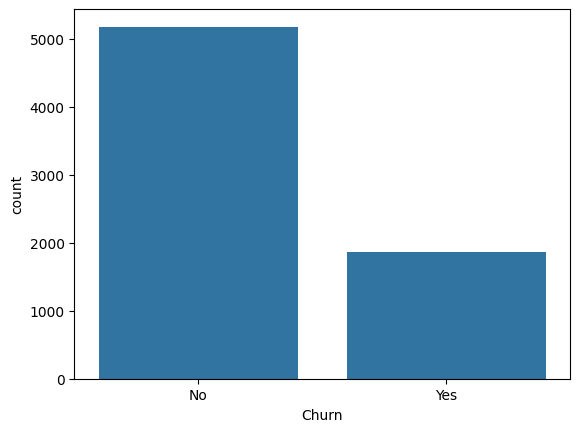

In [24]:
sns.countplot(data=churn_df, x='Churn')

In [25]:
len(churn_df['customerID'].unique()) # Все айди уникальные

7043

### Вывод: нет пропусков, TotalCharges - object (должен быть float), дисбаланс классов

### 2.2 Анализ категориальных признаков

In [26]:
cat_features = [col for col in churn_df.columns if len(churn_df[col].unique()) < 10]
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

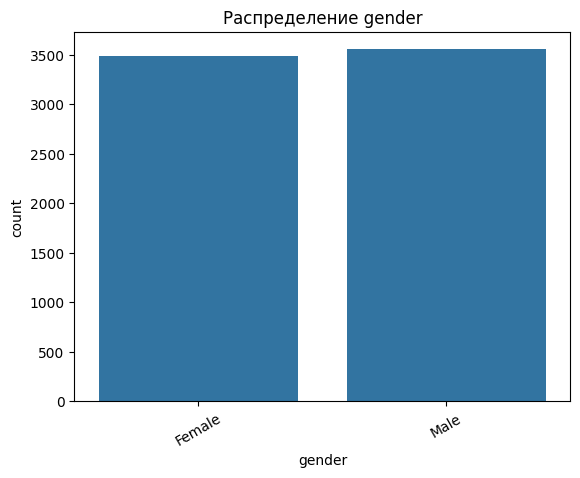

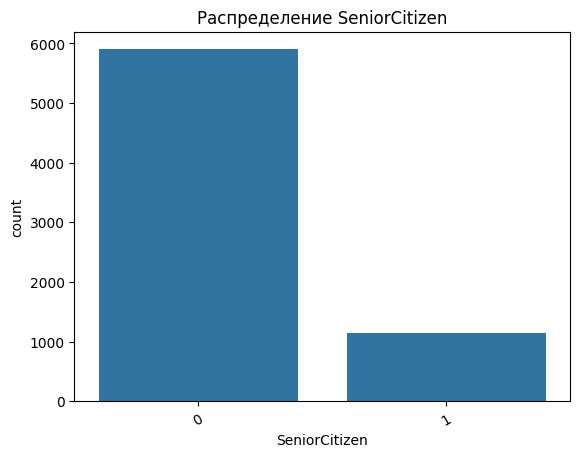

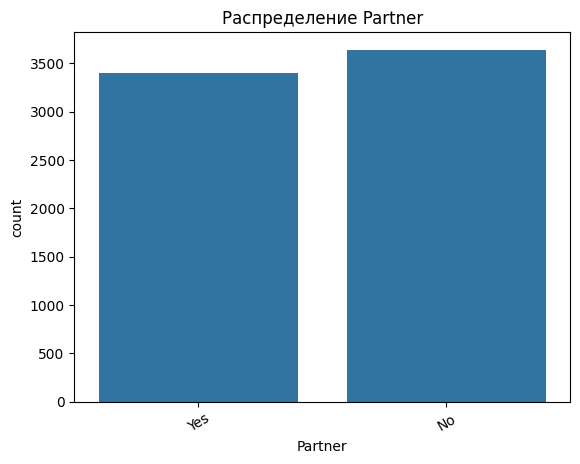

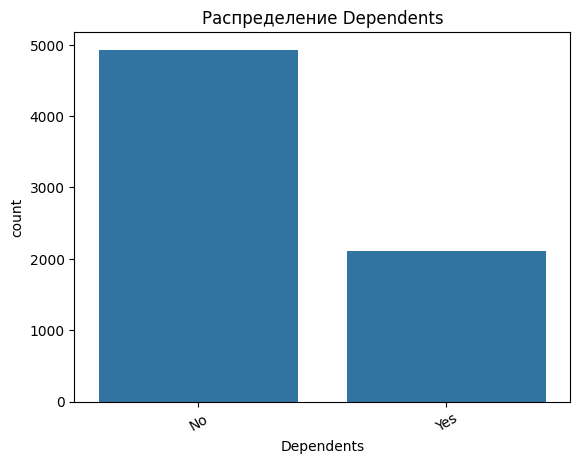

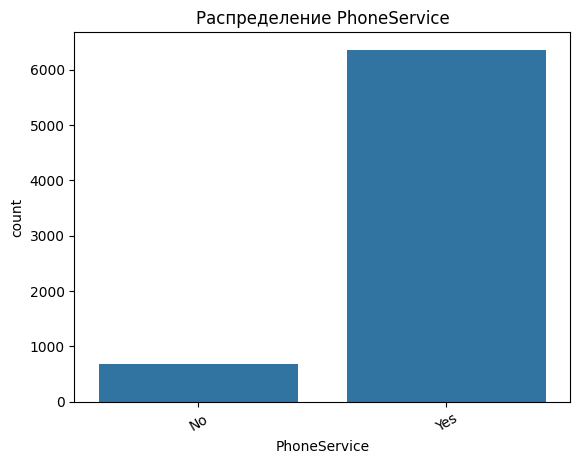

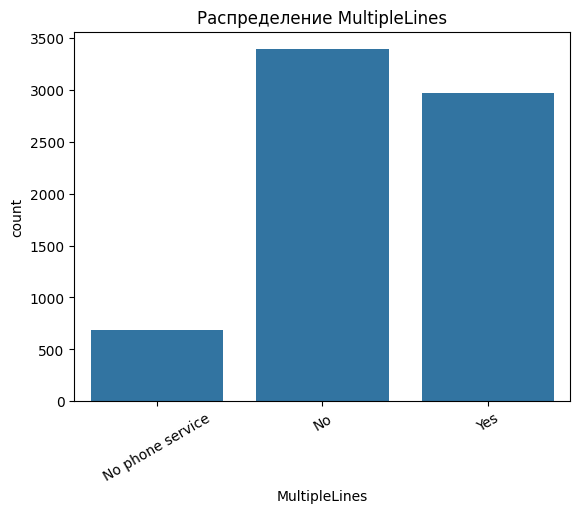

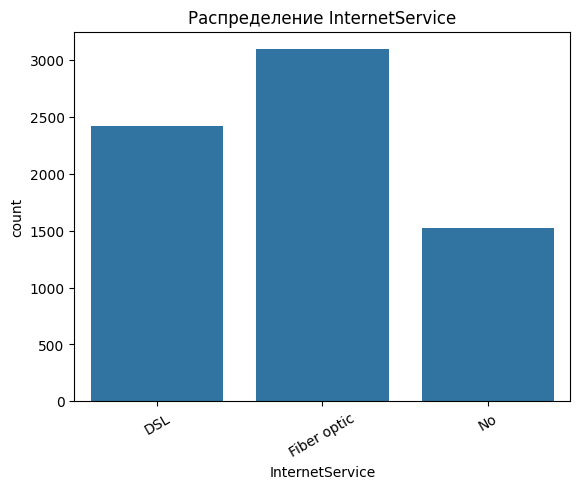

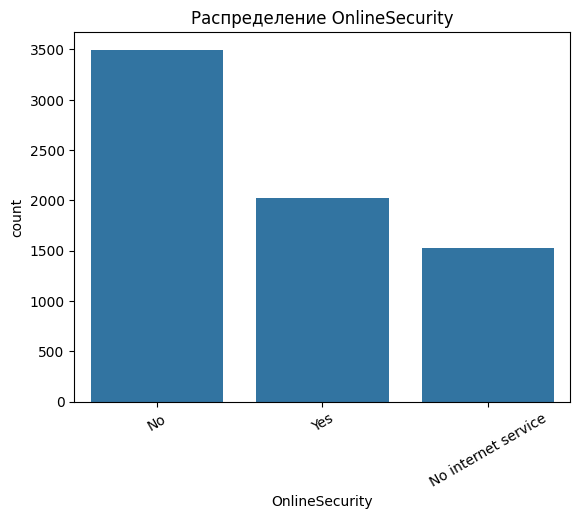

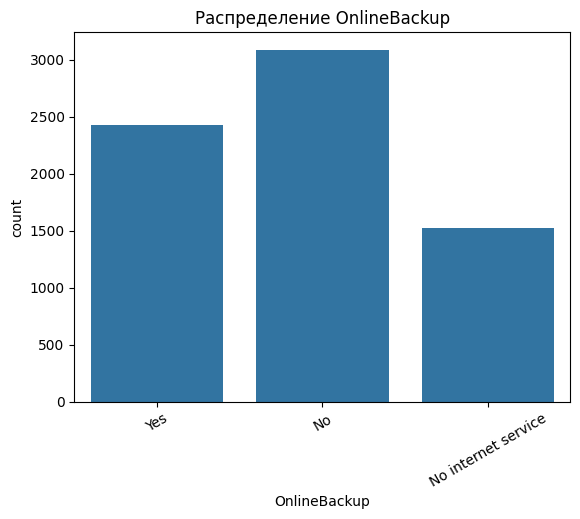

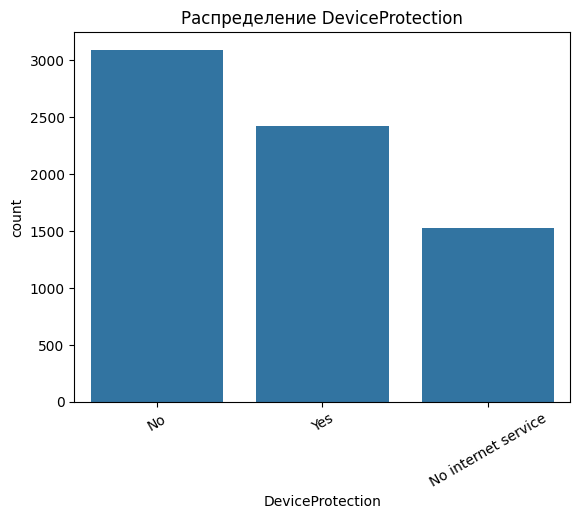

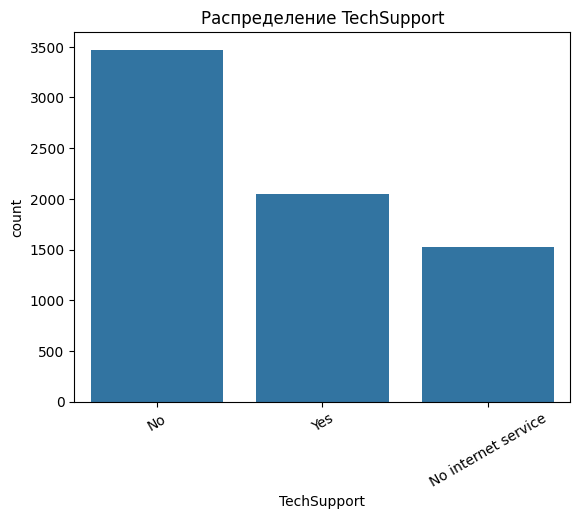

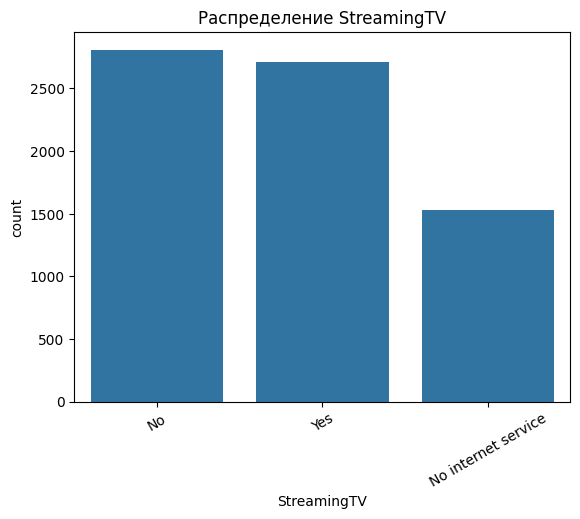

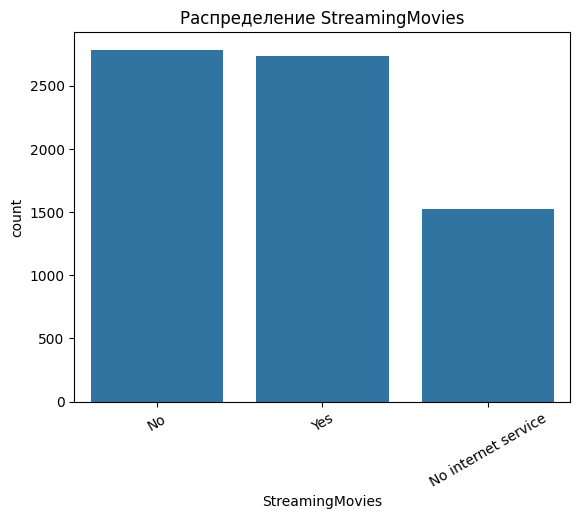

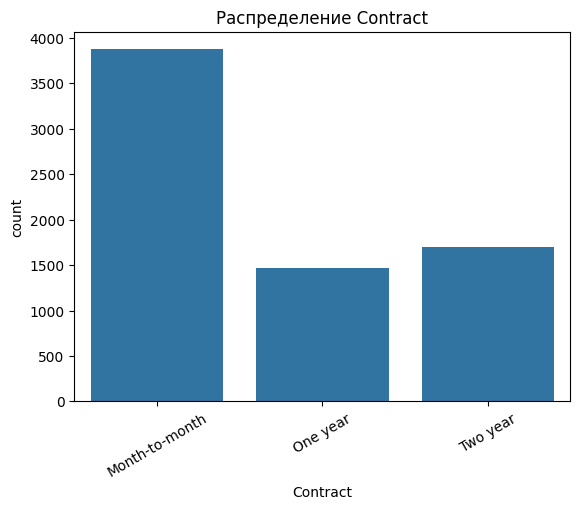

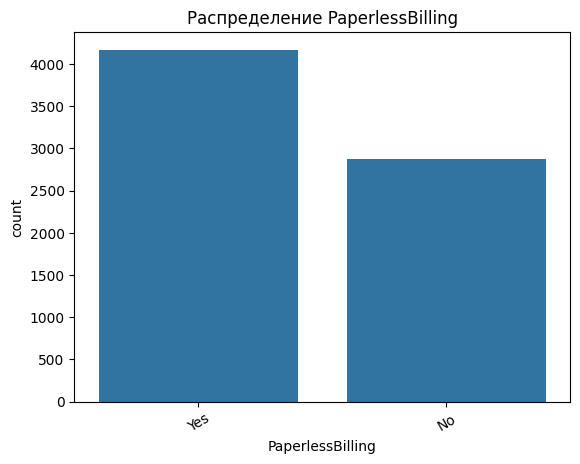

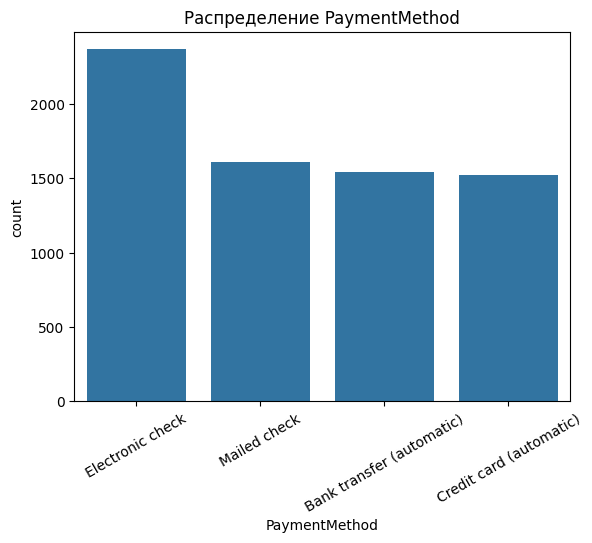

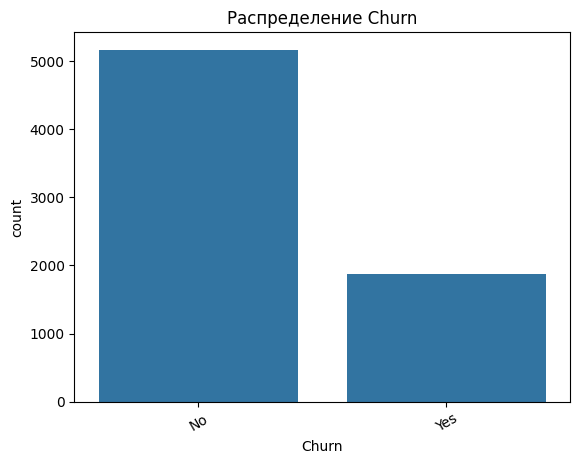

In [27]:
for feature in cat_features:
    sns.countplot(data=churn_df, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=30)
    plt.show()

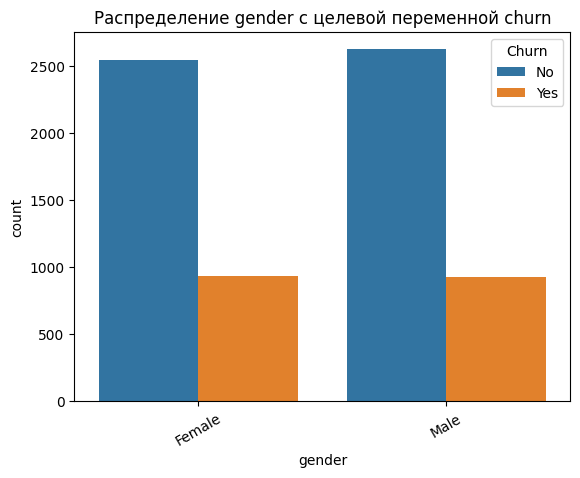

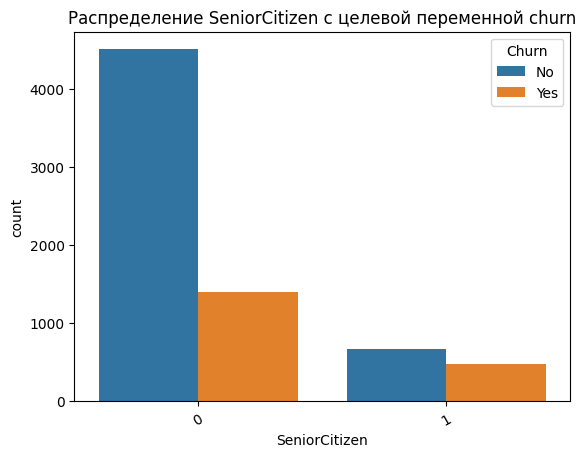

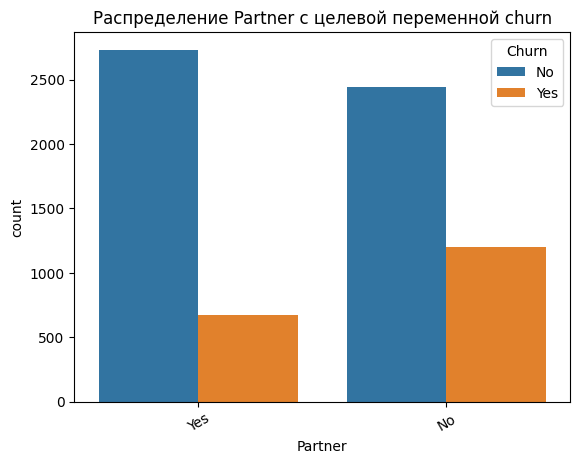

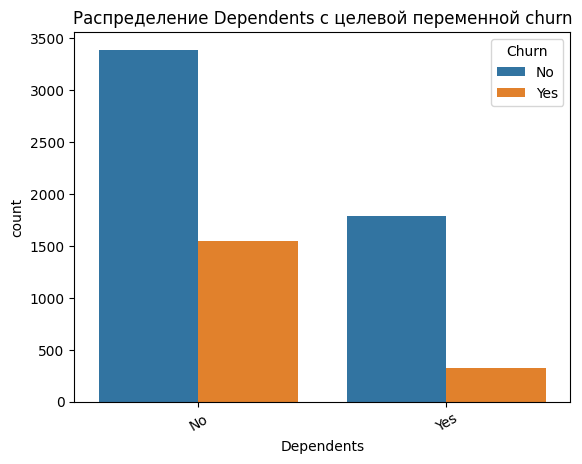

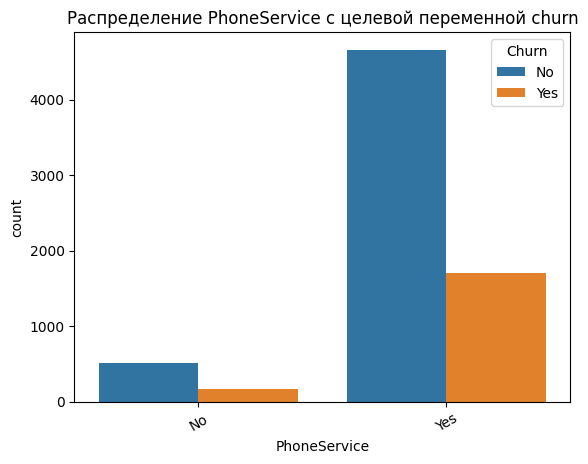

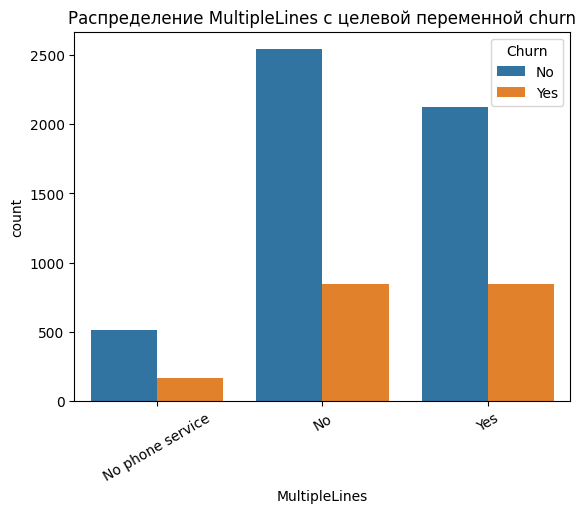

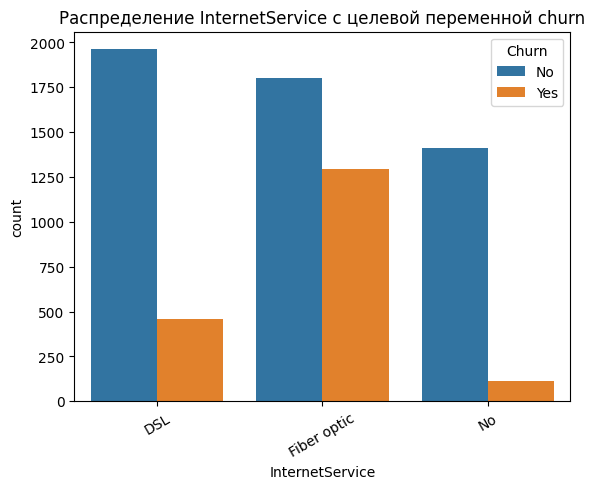

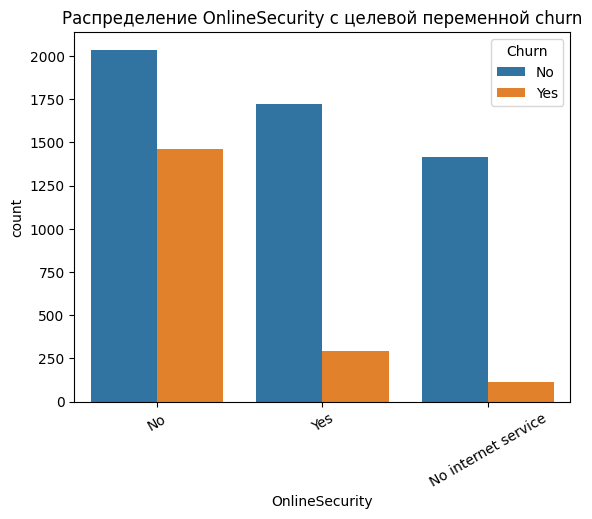

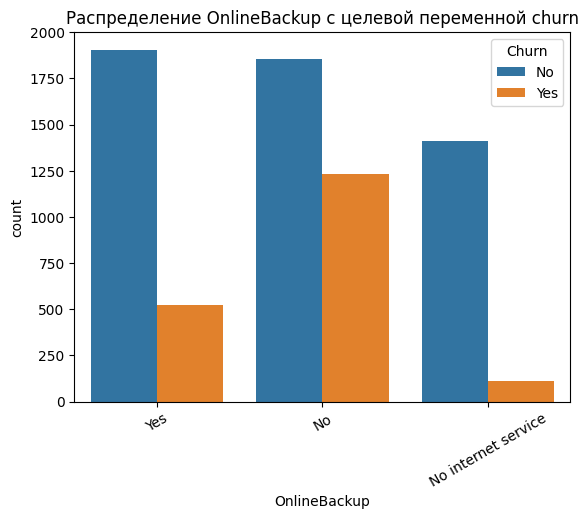

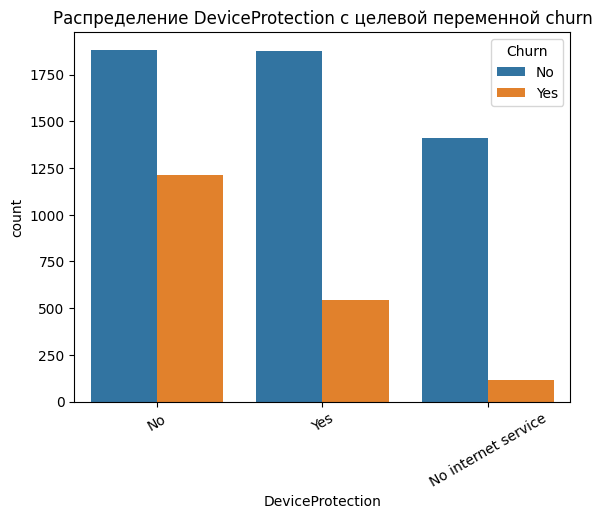

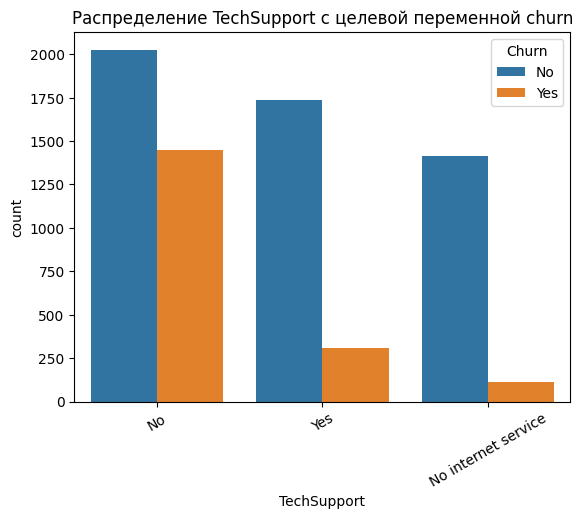

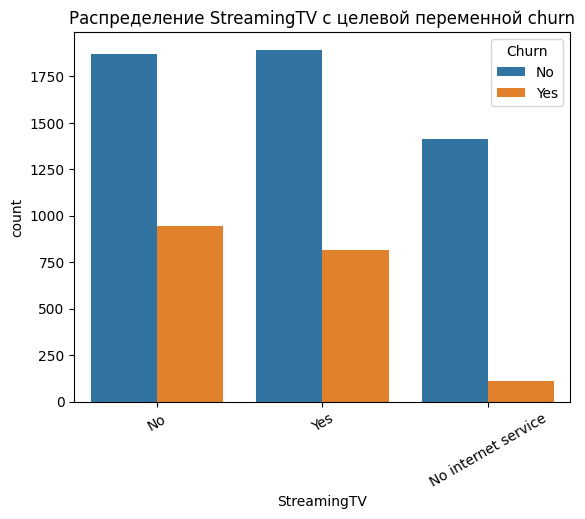

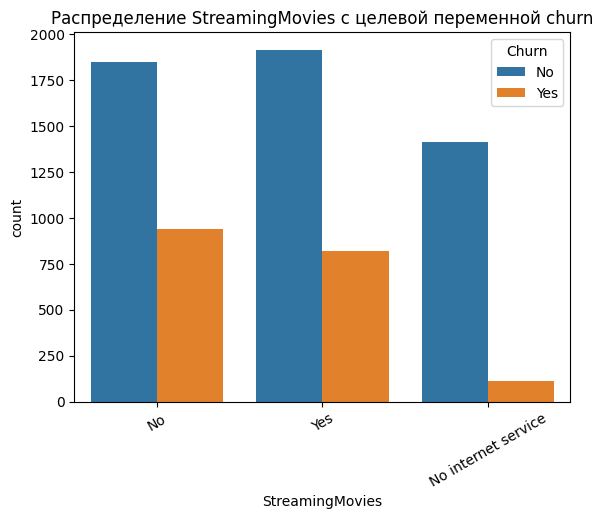

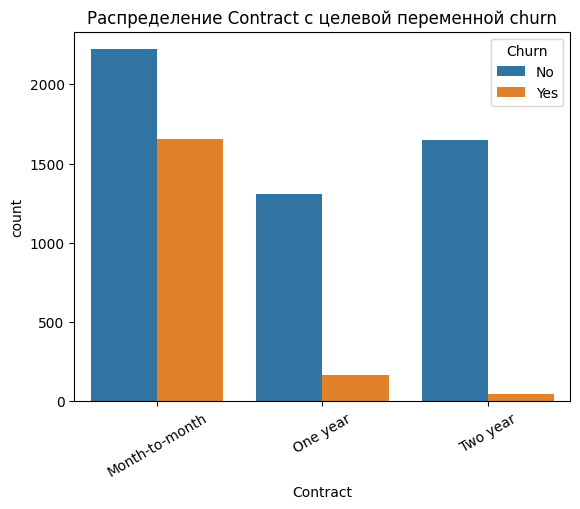

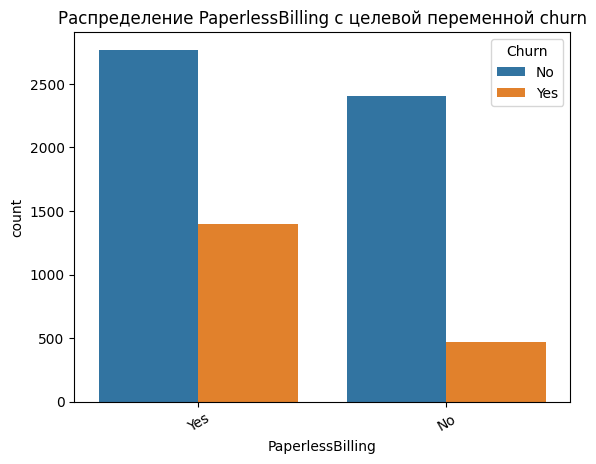

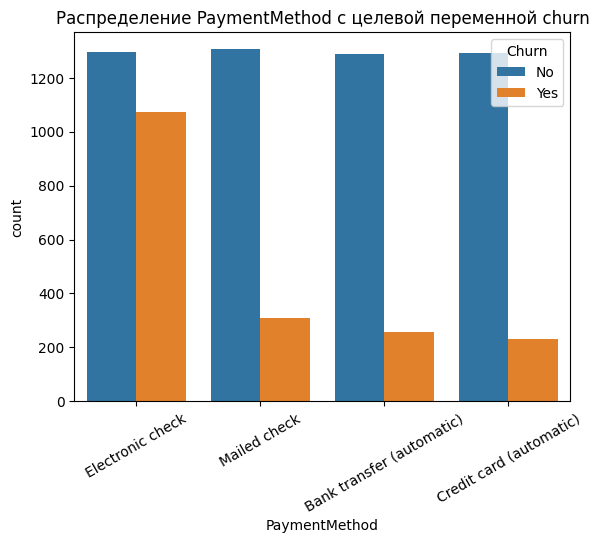

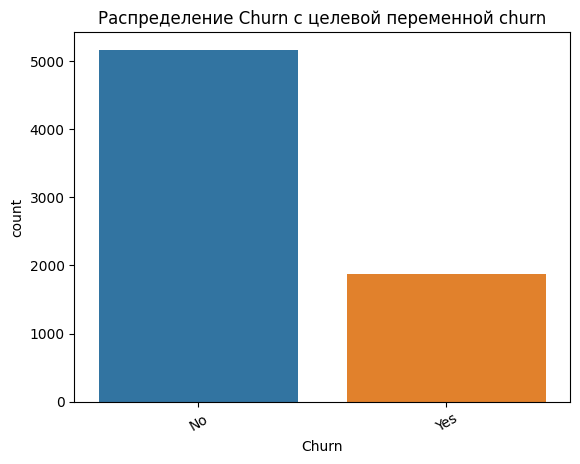

In [28]:
for feature in cat_features:
    sns.countplot(data=churn_df, x=feature, hue='Churn')
    plt.title(f'Распределение {feature} с целевой переменной churn')
    plt.xticks(rotation=30)
    plt.show()

### Вывод: больше всего влияют Contract, InternetService, PaymentMethod. Пол (gender) не влияет

### 2.3 Анализ непрерывных признаков
Разберемся с признаком TotalCharges. В нем числовые значения , но у самого столбца тип - object 

In [29]:
churn_df[-churn_df['TotalCharges'].str.isnumeric()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[6719 rows x 21 columns]

In [30]:
# Преобразуем этот столбец в тип данных float 
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')

In [31]:
churn_df['TotalCharges'].dtype

dtype('float64')

In [32]:
churn_df.isnull().sum()
# Появились значения NaN. Видимо в TotalCharges были пропущенные значения и 
# когда мы присваивали признаку числовой тип, эти значения стали значениями NaN  

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [33]:
churn_df[churn_df['TotalCharges'].isnull()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   
3331          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
4380          Yes                No              No  No internet service  ...   
5218          Yes                No              No  No internet service  ...   
6670          Yes               Yes             DSL                   No  ...   
6754          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   
3331  No internet service  Two year               No   
3826  No internet service  Two year               No   
4380  No internet service  Two year               No   
5218  No internet service  One year              Yes   
6670                   No  Two year               No   
6754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
488   Bank transfer (automatic)          52.55           NaN     No  
753                Mailed check          20.25           NaN     No  
936                Mailed check          80.85           NaN     No  
1082               Mailed check          25.75           NaN     No  
1340    Credit card (automatic)          56.05           NaN     No  
3331               Mailed check          19.85           NaN     No  
3826               Mailed check          25.35           NaN     No  
4380               Mailed check          20.00           NaN     No  
5218               Mailed check     

In [34]:
# Заменим пропущенные значения на ноль , ведь скорее всего это новые клиенты, которые только что подключились
# У них есть MonthlyCharges, но TotalCharges еще не успели начислить
churn_df['TotalCharges'] = churn_df['TotalCharges'].fillna(0)

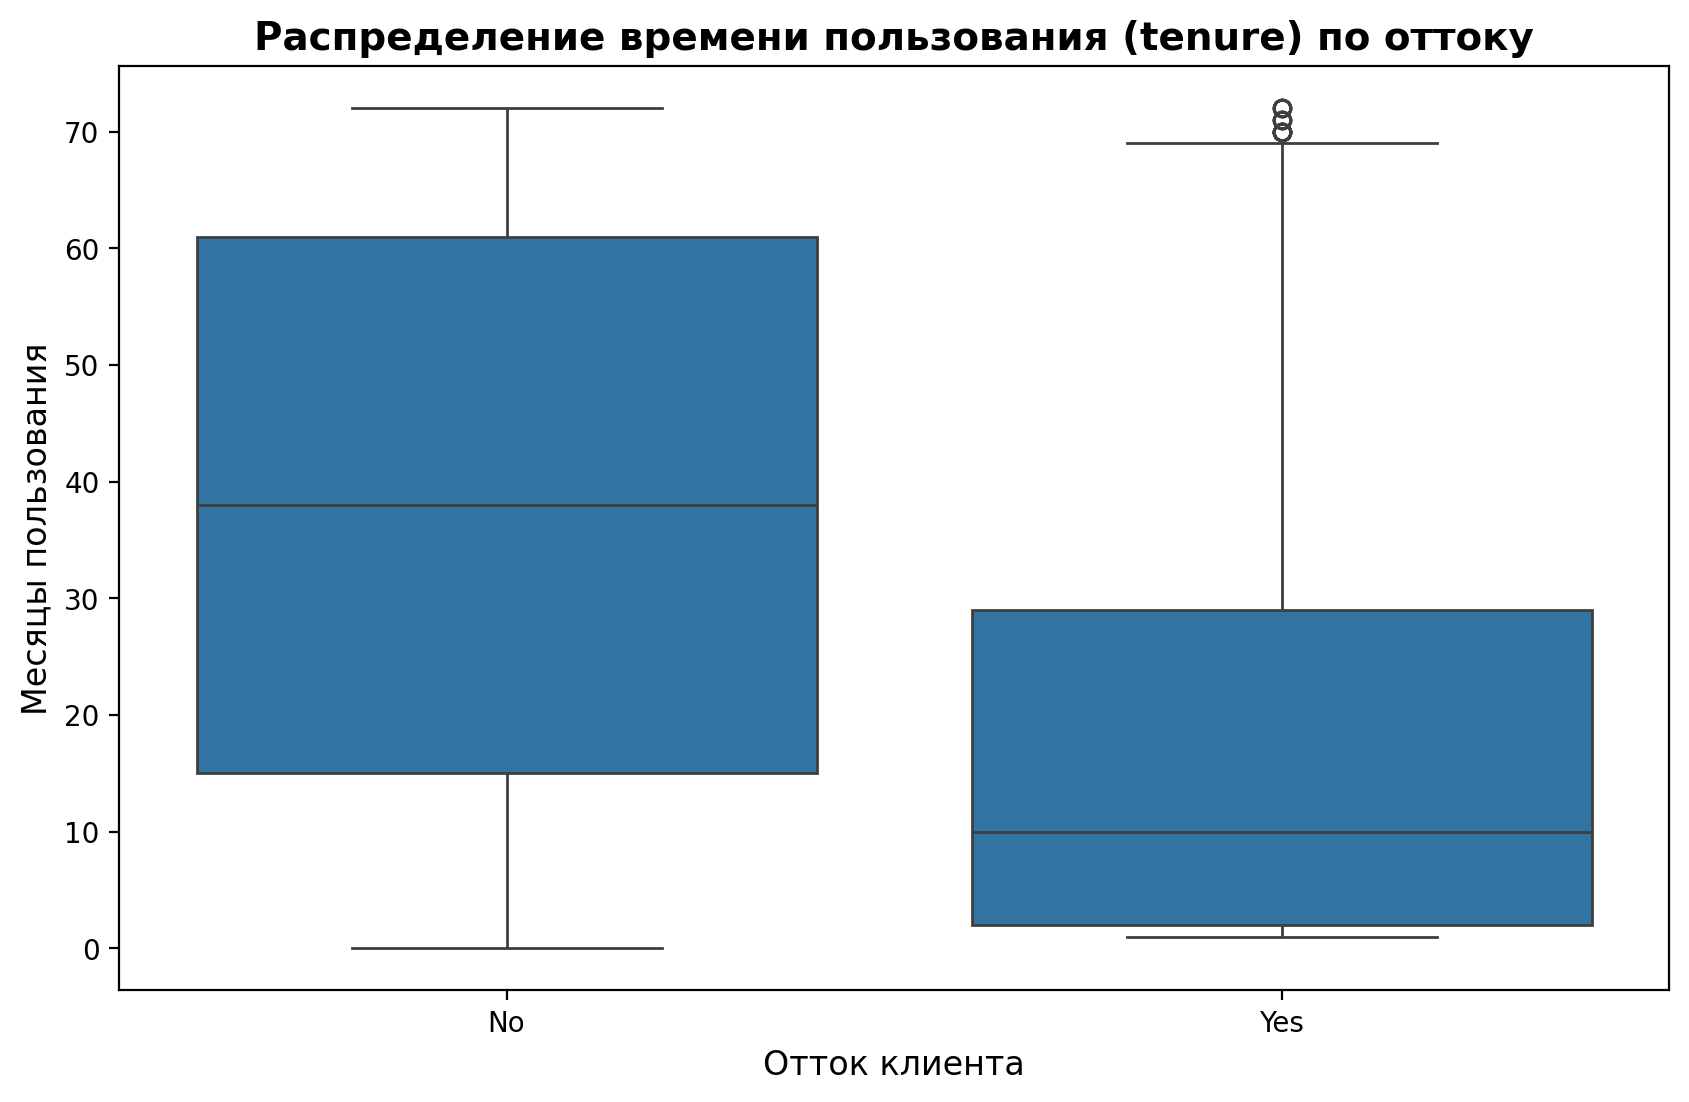

In [35]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='tenure')
plt.title('Распределение времени пользования (tenure) по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Месяцы пользования', fontsize=12)
plt.show()

### Вывод: У уходящих клиентов значительно меньше tenure (медиана около 10 мес), а у оставшихся клиентов медиана около 40 мес)

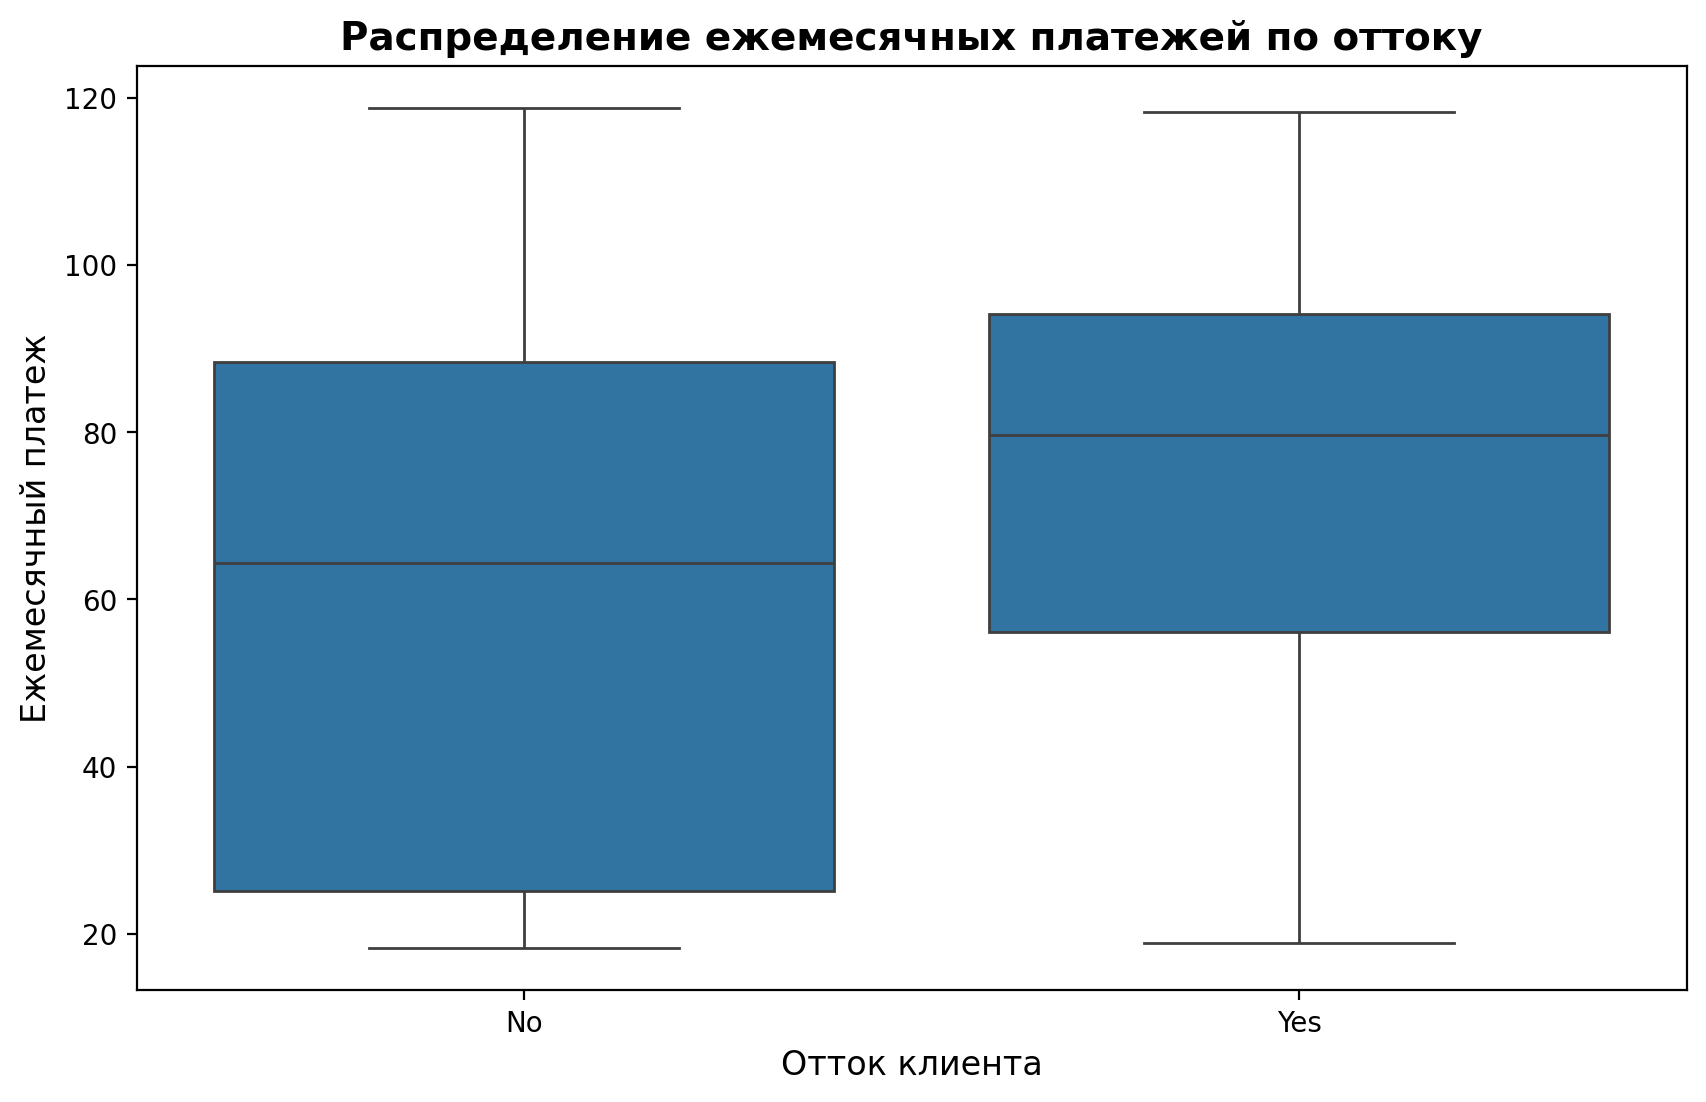

In [36]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='MonthlyCharges')
plt.title('Распределение ежемесячных платежей по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Ежемесячный платеж', fontsize=12)
plt.show()

### Вывод: У уходящих клиентов выше MonthlyCharges (медиана около 80)

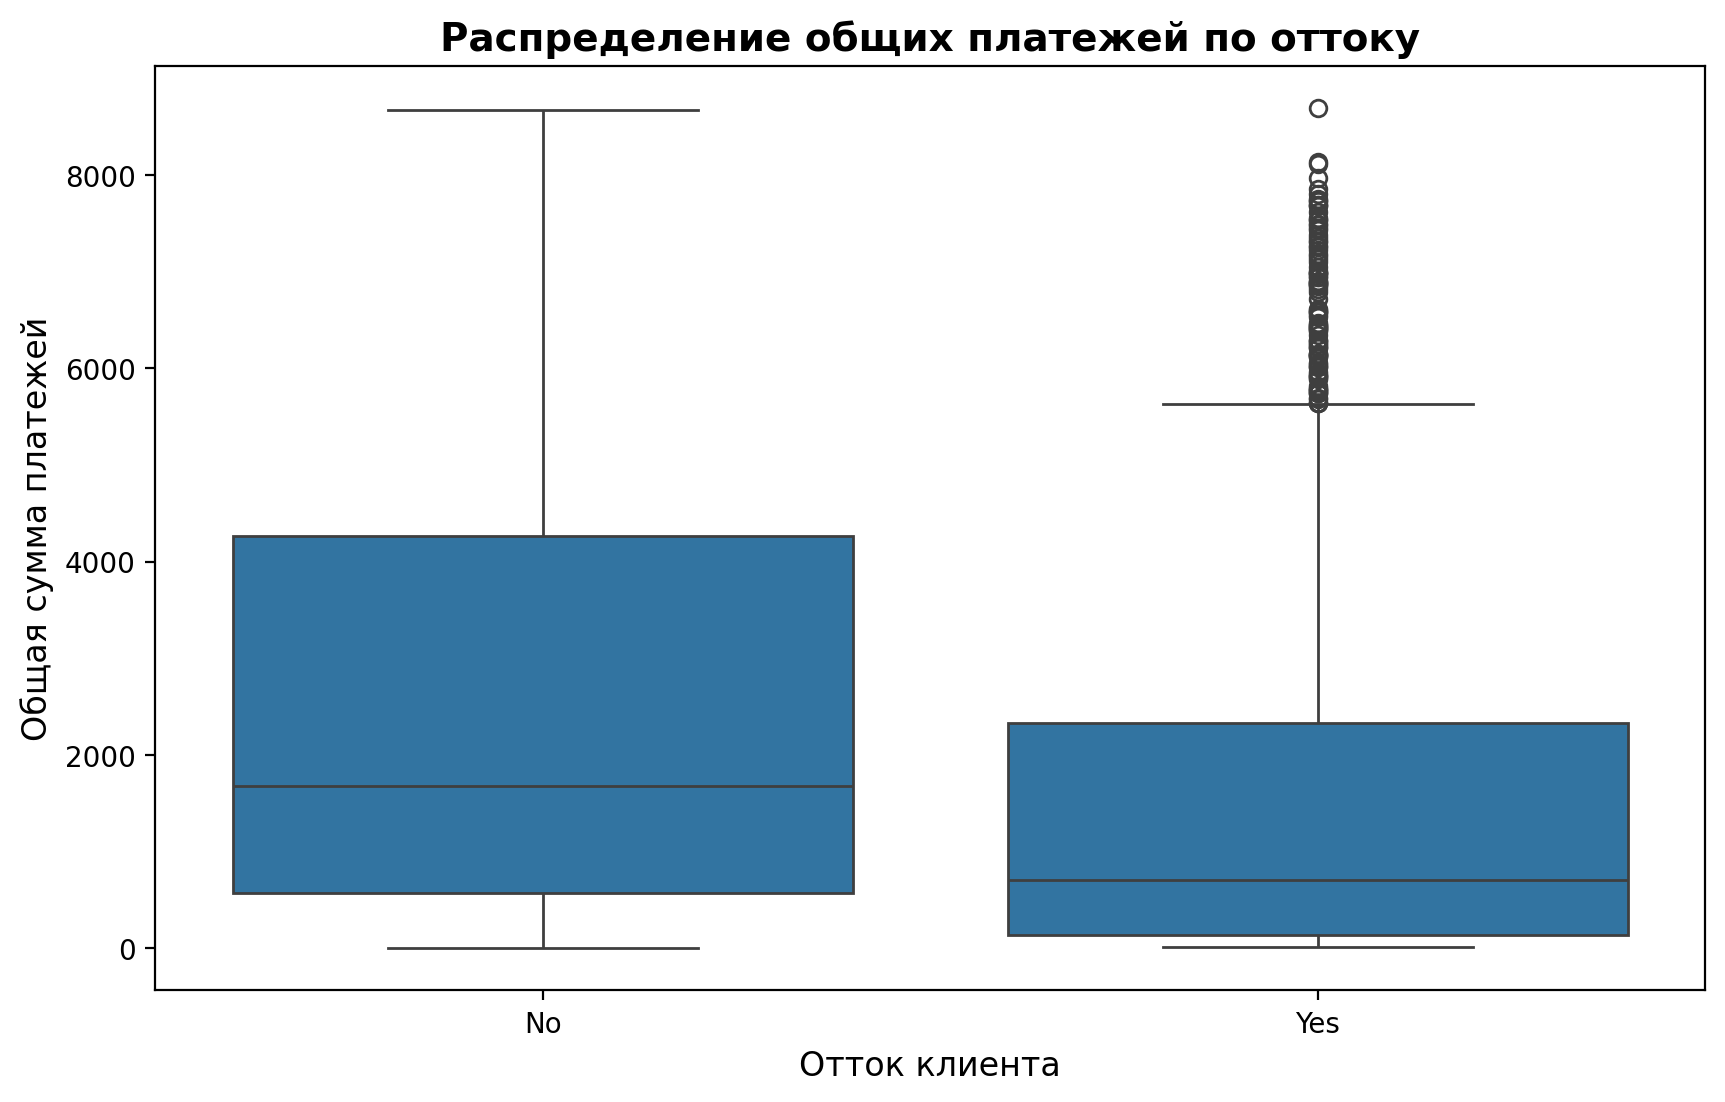

In [37]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='TotalCharges')
plt.title('Распределение общих платежей по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Общая сумма платежей', fontsize=12)
plt.show()

### Вывод: у уходящих клиентов ниже TotalCharges, следовательно они недолго были клиентами

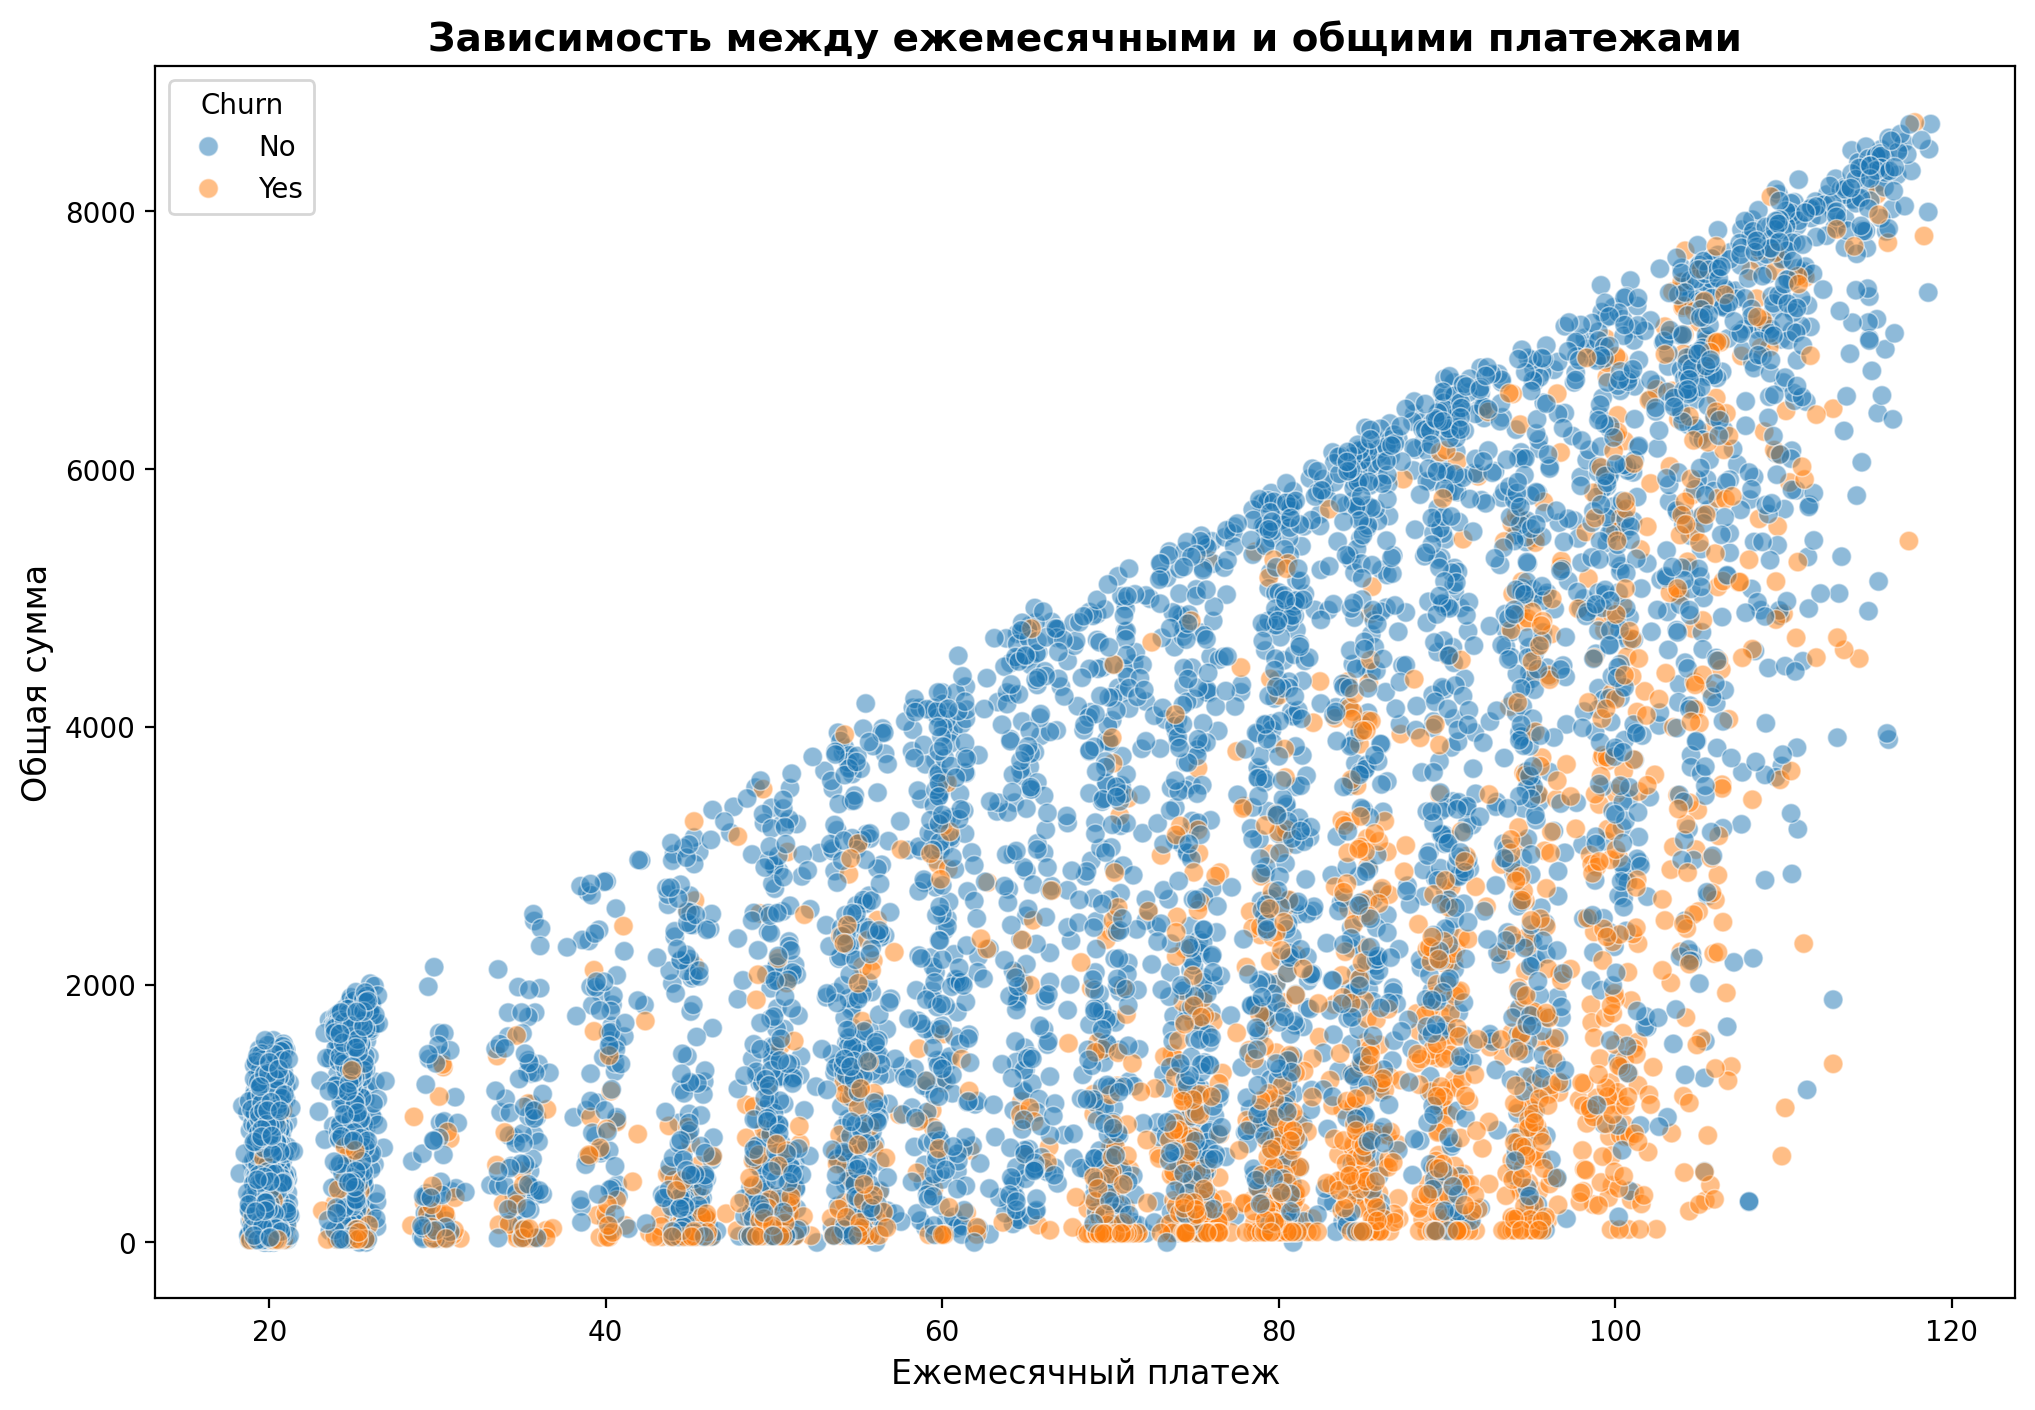

In [38]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=churn_df, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.5, s=50)
plt.title('Зависимость между ежемесячными и общими платежами', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Общая сумма', fontsize=12)
plt.show()

### Вывод: Клиенты с высокими MonthlyCharges но низкими TotalCharges (новые клиенты с дорогими тарифами) часто уходят

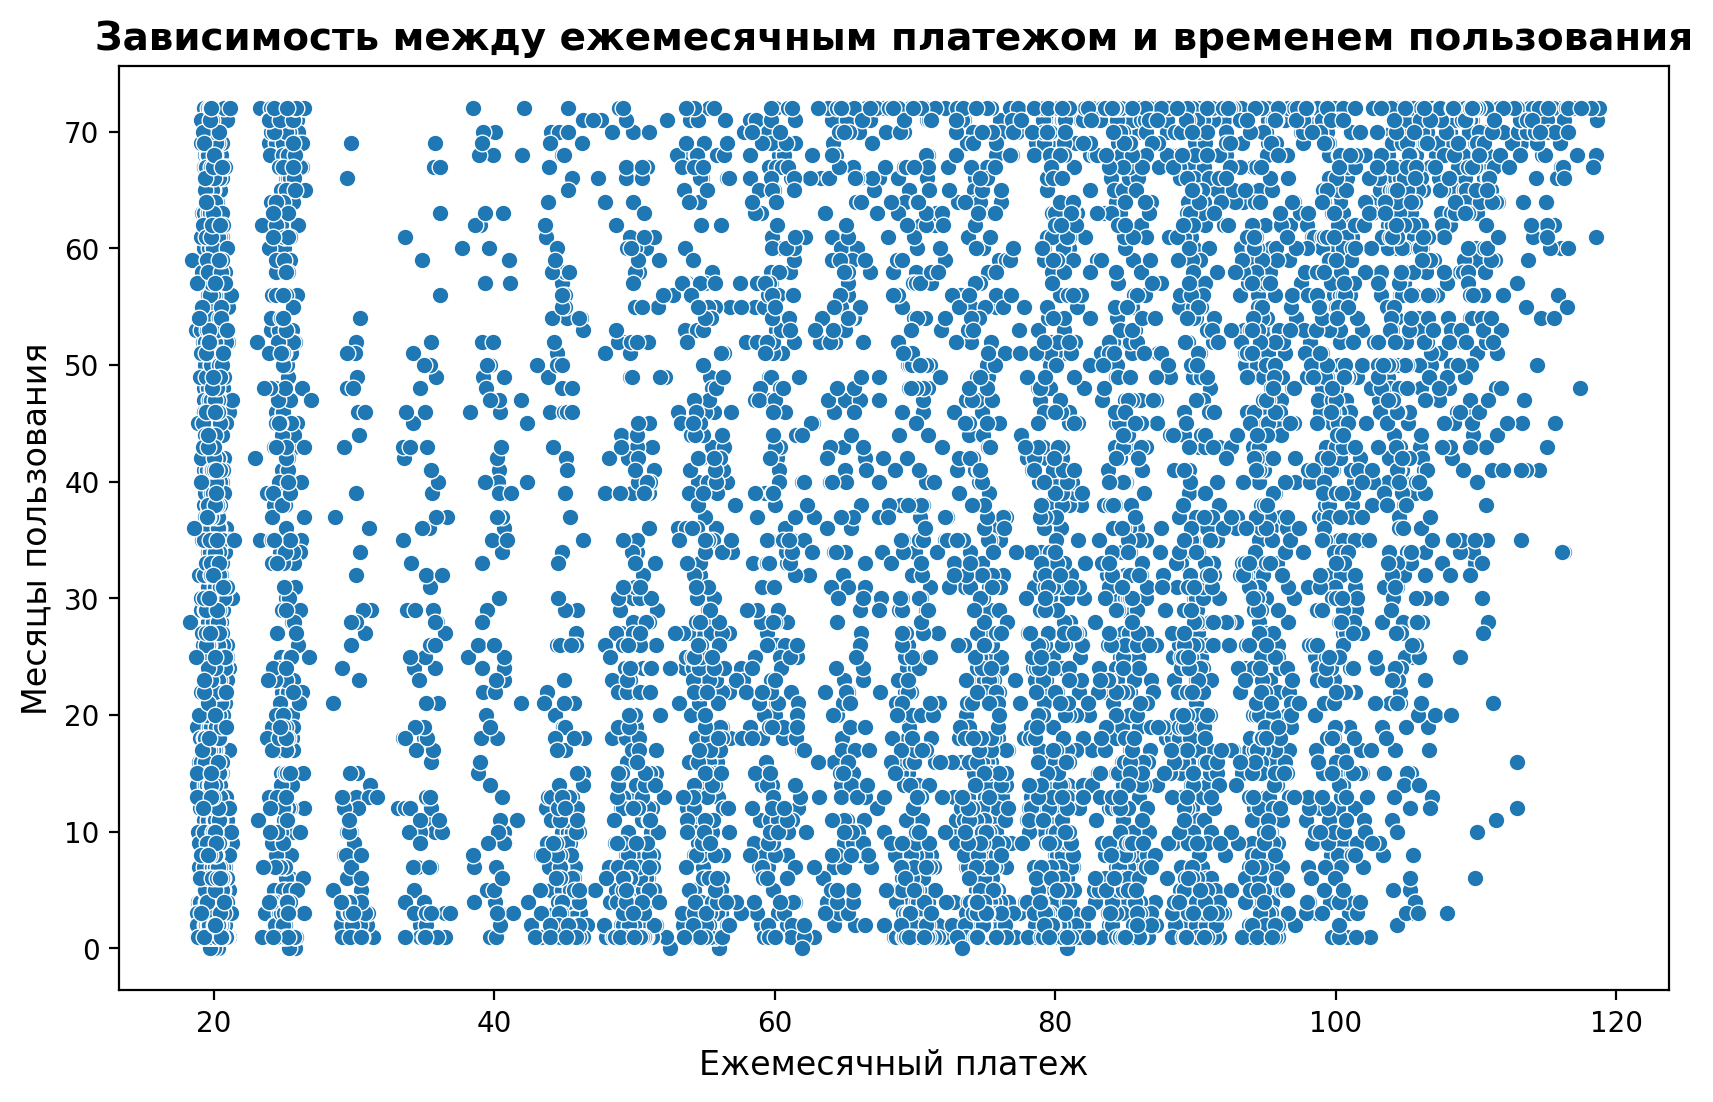

In [39]:
plt.figure(figsize=(10, 6), dpi=200)
sns.scatterplot(data=churn_df, x='MonthlyCharges', y='tenure')
plt.title('Зависимость между ежемесячным платежом и временем пользования', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Месяцы пользования', fontsize=12)
plt.show()

### Вывод: Нет явной линейной зависимости между MonthlyCharges и tenure

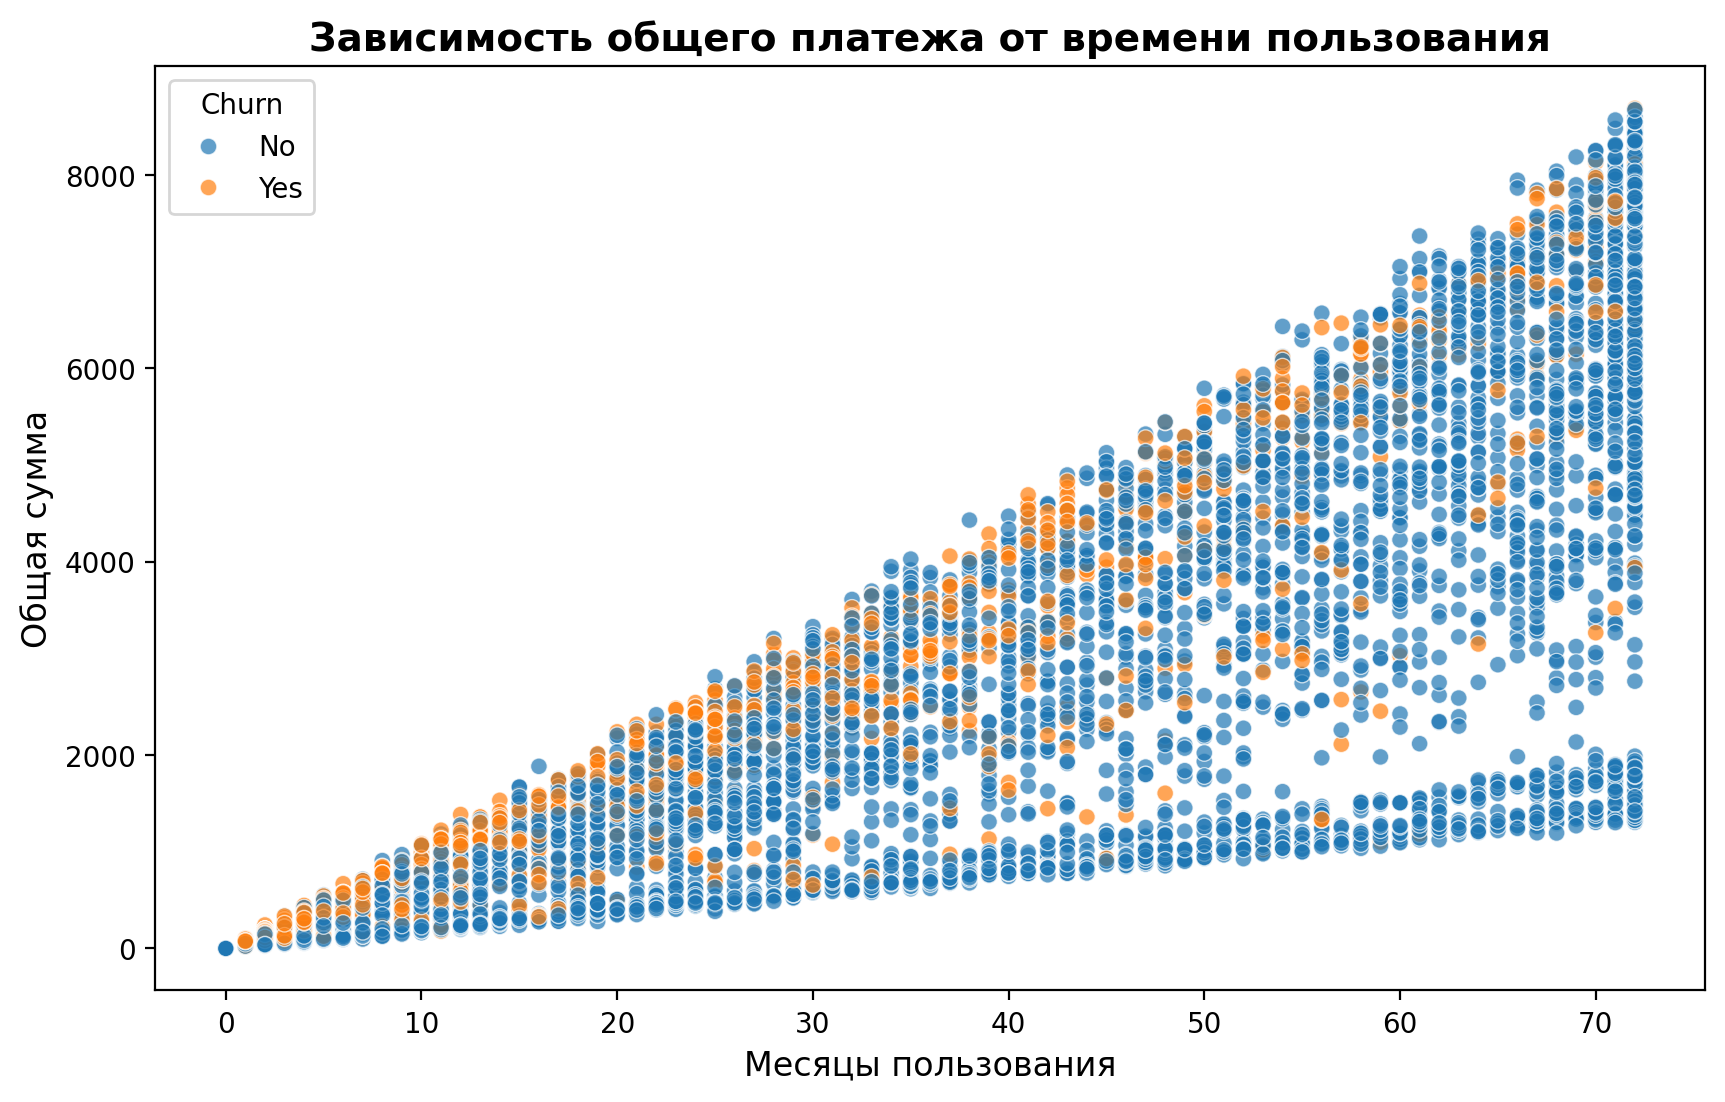

In [40]:
plt.figure(figsize=(10, 6), dpi=200)
sns.scatterplot(data=churn_df, x='tenure', y='TotalCharges', hue='Churn', alpha=0.7)
plt.title('Зависимость общего платежа от времени пользования', fontsize=14, fontweight='bold')
plt.xlabel('Месяцы пользования', fontsize=12)
plt.ylabel('Общая сумма', fontsize=12)
plt.show()

### Вывод: Клиенты с маленьким tenure и низкими TotalCharges часто уходят

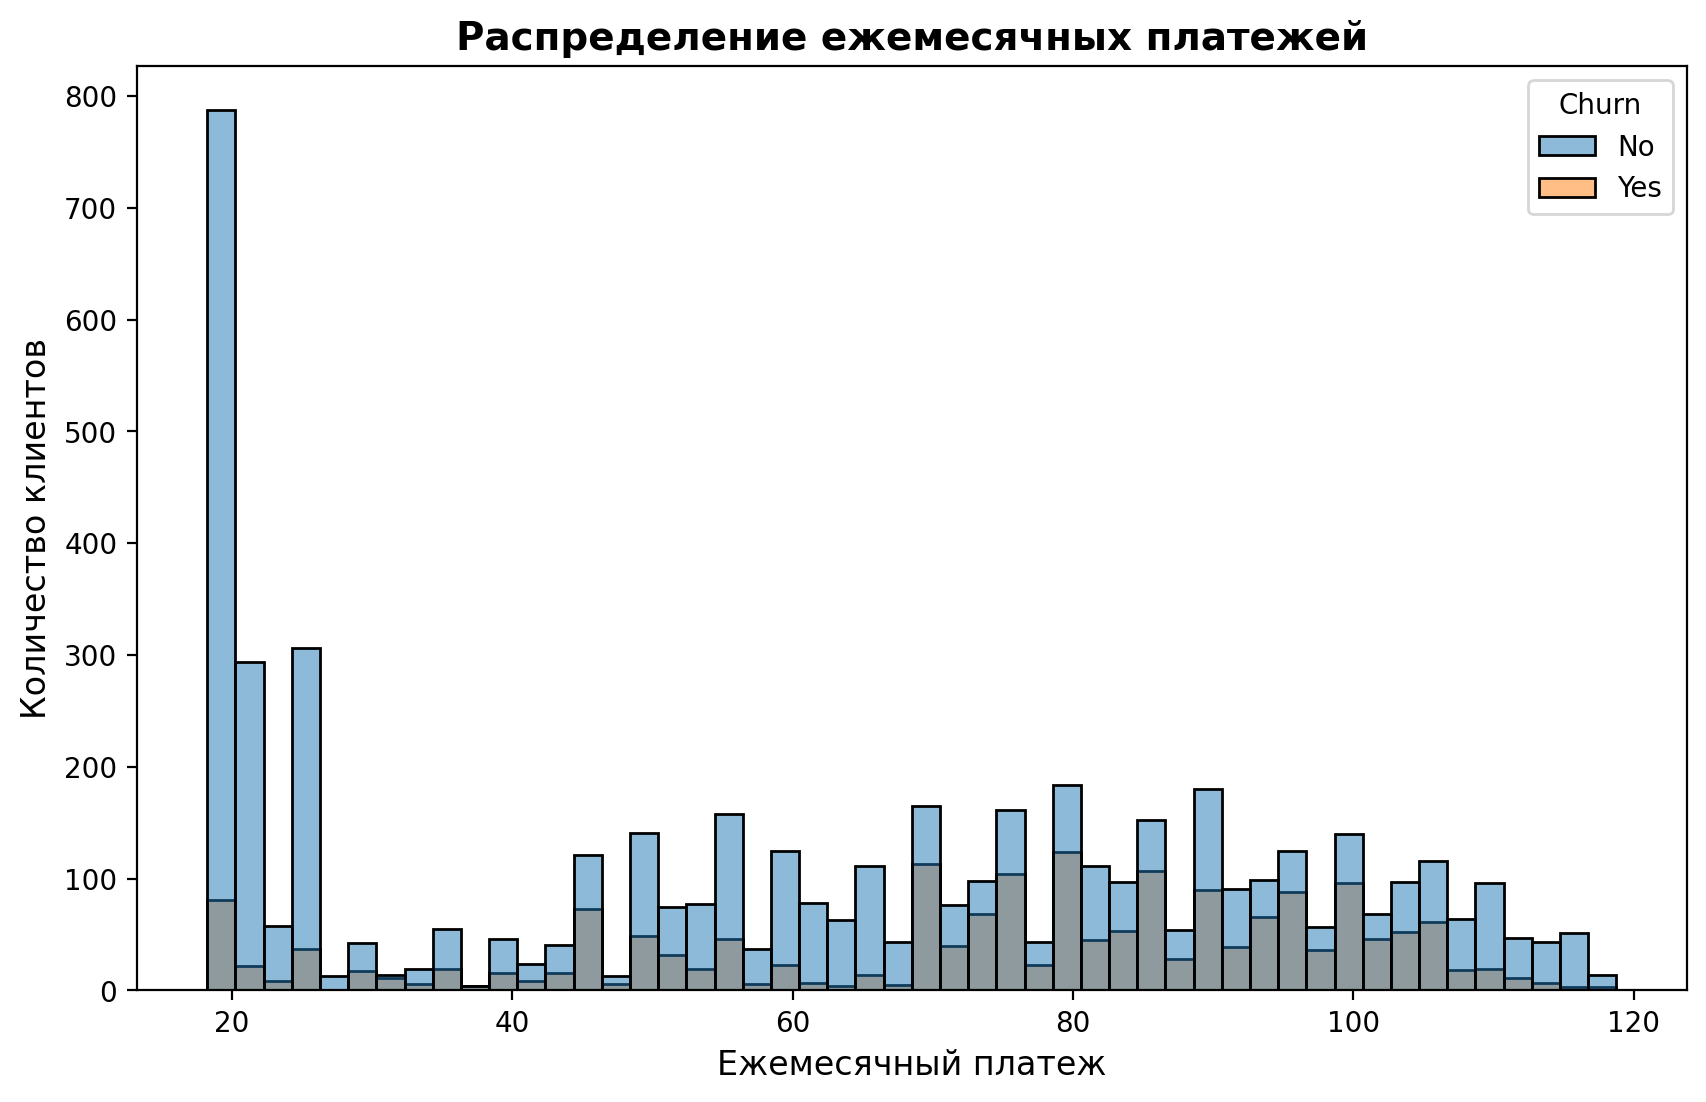

In [41]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data=churn_df, x='MonthlyCharges', hue='Churn', bins=50)
plt.title('Распределение ежемесячных платежей', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

### Вывод: Уходящие клиенты чаще в диапазоне 70-100

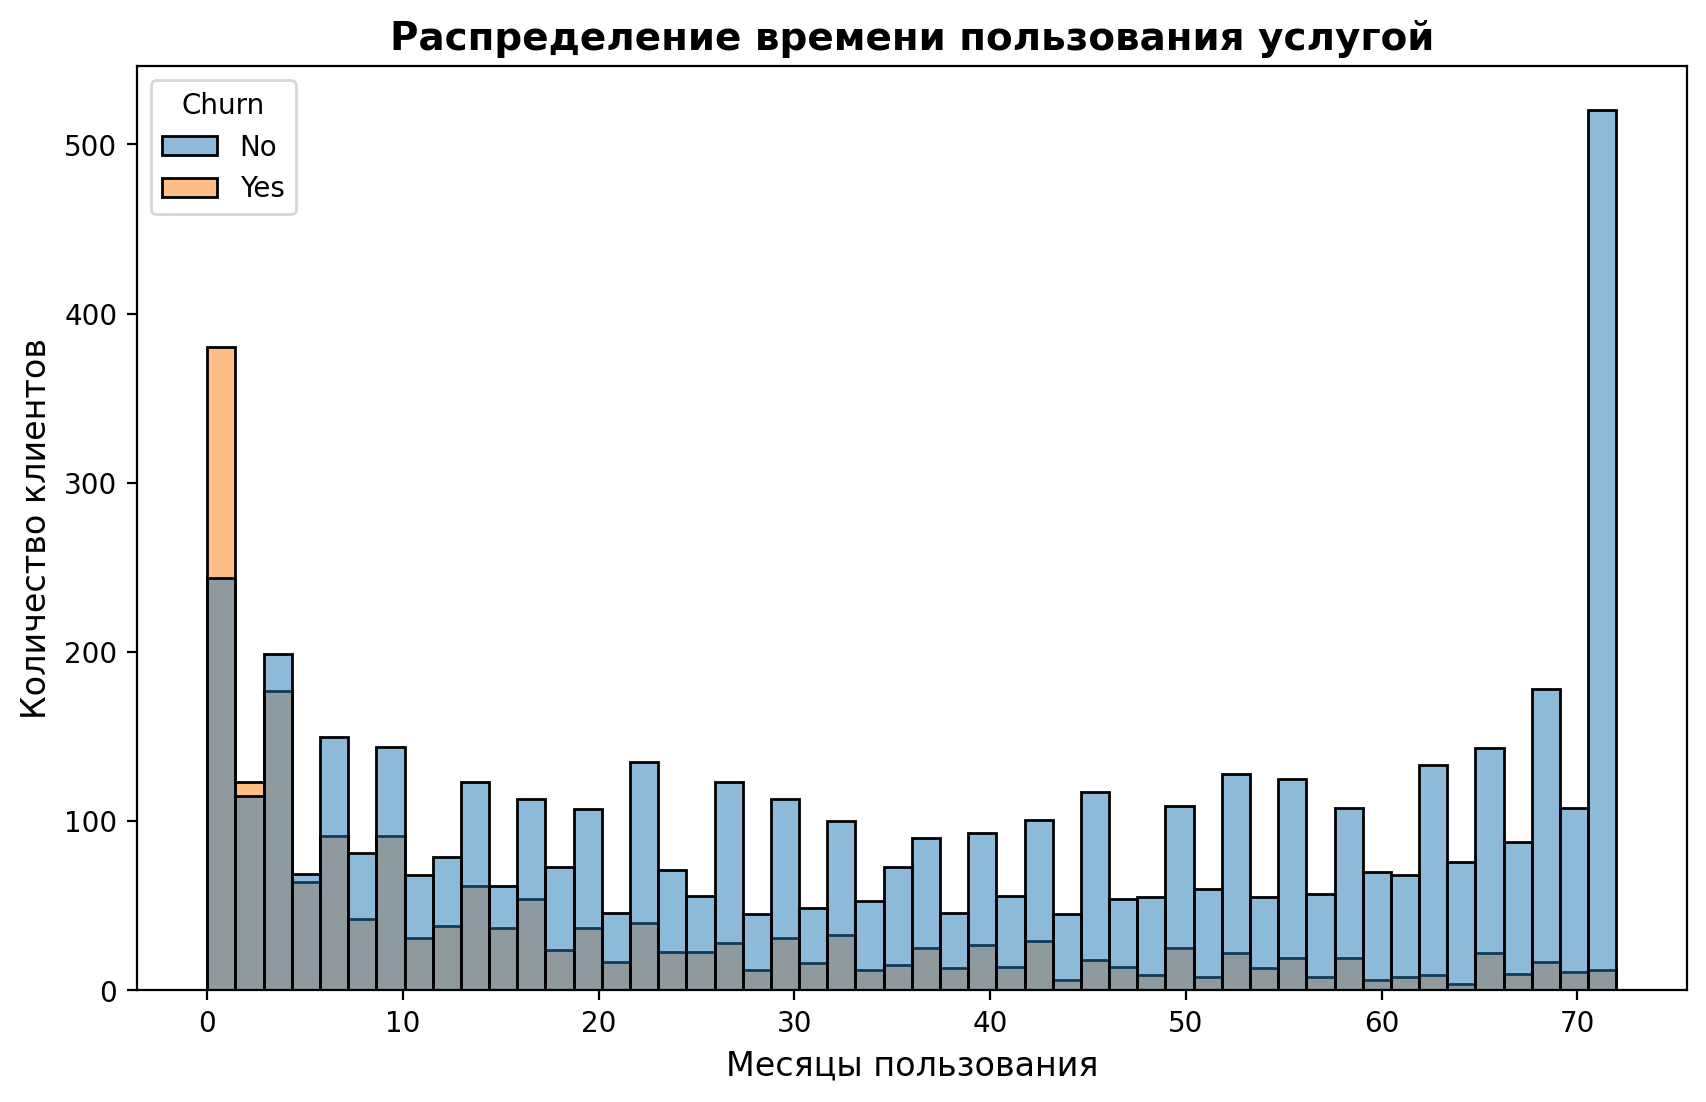

In [42]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data=churn_df, x='tenure', hue='Churn', bins=50)
plt.title('Распределение времени пользования услугой', fontsize=14, fontweight='bold')
plt.xlabel('Месяцы пользования', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

### Вывод: Новые клиенты (первые 10 месяцев) чаще уходят. После 30 месяцев отток минимален

In [43]:
# Создадим числовой признак оттока где 1 это клиент покинул компанию
churn_df['Churn_num'] = churn_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
churn_df['Churn_num']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn_num, Length: 7043, dtype: int64

In [44]:
plt.figure(figsize=(10, 6), dpi=200)
sns.heatmap(data=churn_df.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков', fontsize=14, fontweight='bold')
plt.show()

ValueError: could not convert string to float: '7590-VHVEG'

<Figure size 2000x1200 with 0 Axes>

### Выводы: 

##### Категориальные признаки: 
1) Данные несбалансированы. Стоит обратить внимание
2) Мужчин и женщин одинаковое количество. Также нет зависимости целевой переменной от гендера 
3) Клиентов с партнером и без почти одинаковое количество. Клиенты без партнера немного чаще покидают компанию
4) Если у клиента есть иждивенцы, то он вероятнее всего не покинет компанию
5) У клиентов в 90% случаев есть телефон
6) Чаще всего интернет провайдер: Fiber optic. Далее - DSL. Реже - нет интернет провайдера. Если интернет провадер Fiber optic, то вероятность что клиент покинет компанию больше чем при интернет провайдере DSL или при отсутствии провайдера. При отсутствии провайдера очень низкая вероятность того, что клиент покинет компанию 
7) Чаще всего у клиентов нет онлайн защиты (OnlineSecurity), резервного копирования (OnlineBackup),  защиты устройств (DeviceProtection) и технической поддержки (TechSupport). Но если хотя бы одна из этих услуг подключена или у пользователя вообще нет интернета, то клиент вероятнее всего останется в компании. 
8) Клиентов со стриминговым тв такое же кол-во как и клиентов без этой функции. То же самое с клиентами с доступом к стриминговым фильмам. Клиентов с доступом и без доступа равное количество. Наличие стримингового тв и доступа к стриминговым фильмам почти не влияет на целевую переменную 
9) Больше клиентов с контрактом на месяц. Но такие клиенты гораздо чаще покидают компанию. На втором месте по количеству - клиенты с двухлетним контрактов. И они реже всего покидают компанию (почти никогда)
10) У клиентов чаще всего есть возможность получать счета на бумаге. Клиенты с такой возможностью чаще уходят из компании 
11) Наиболее часто используемый способ оплаты это Electronic check. При оплате электронным чеком клиенты гораздо чаще покидают компанию, чем при оплате остальными способами. Другие способы: Mailed check, Bank transfer (automatic), Credit card(automatic) используются с одинаковой частотой. 

##### Непрерывные признаки: 
1) Кол-во месяцев в течение которых клиент сотрудничал с компанией сильно влияет на целевую переменную. Чаще уходят клиенты у которых короткое время пользования (в основном до 20 месяцев), медиана около 10 месяцев. Клиенты, которые ОСТАЛИСЬ (Churn = No): Долгое время пользования (в основном от 30+ месяцев), медиана около 40 месяцев, много "постоянных" клиентов
2) Чаще уходят клиенты с более высоким MonthlyCharges (ежемесячным платежом). В основном он от 60. Медиана = 80 
3) ?? С общей суммой оплаты непонятно. Непонятно как она влияет на целевую переменную. Много выбросов в боксплоте
4) Чаще всего MonthlyCharges около 20. А больший отток клиентов происходит когда ежемесячная сумма в диапазоне от 70 до 110
5) На дисплоте общей суммы видим большое кол-во клиентов которые ушли из компании, но у них низкий TotalCharges . Скорее всего эти клиенты просто пробыли в компании маленькое кол-во месяцев и ушли (под вопросом)
6) Чем больше месяцев клиент в компании - тем больше вероятность что он не уйдет в отток. В отток чаще всего уходят пользователи которые сотрудничали с компанией до 5-10 месяцев

### 2.5 Глубокий анализ через сводные таблицы

In [ ]:
pd.pivot_table(churn_df, index=['gender', 'Partner'], values='Churn_num', aggfunc=['count', 'mean']) 
# Выяснили что наличие партнера влияет на отток 

In [ ]:
pd.pivot_table(churn_df, index=['gender', 'SeniorCitizen'], values='Churn_num', aggfunc=['count', 'mean'])
# У пожилых клиентов высокий процент ухода в отток 

In [ ]:
pd.pivot_table(churn_df, index=['SeniorCitizen', 'Partner', 'Dependents'], values='Churn_num', aggfunc=['count', 'mean'])
# Пожилой человек без партнера более склонен уйти в отток SeniorCitizen

In [ ]:
pd.pivot_table(churn_df, index=['Dependents', 'gender'], values='Churn_num', aggfunc=['count', 'mean'])
# Вне зависимости от пола если есть иждивенцы, то меньше вероятность оттока

In [ ]:
pd.pivot_table(churn_df, index=['Dependents', 'Partner'], values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты без партнёра и иждивенцев - группа повышенного риска оттока 

In [ ]:
pd.pivot_table(churn_df, index=['PhoneService', 'SeniorCitizen'], values='Churn_num', aggfunc=['count', 'mean'])
# Достаточно мало пожилых без телефона. Но почти половина из них ушли в отток 

In [ ]:
pd.pivot_table(churn_df, index=['PhoneService', 'InternetService'], values='Churn_num', aggfunc=['count', 'mean'])
# Большой процент оттока среди пользователей у которых интернет провайдер Fiber optic

In [ ]:
pd.pivot_table(churn_df, index=['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'], values='Churn_num', aggfunc=['count', 'mean'])
# Самая высокая вероятность уйти в отток: интернет провайдер Fiber optic и все перечисленные услуги не подключены 
# Самая низкая: все услуги подключены, либо интернета вообще нет 

In [ ]:
pd.pivot_table(churn_df, index=['InternetService', 'StreamingTV', 'StreamingMovies'], values='Churn_num', aggfunc=['count', 'mean'])
# Самая низкая вероятность оттока: InternetService = DSL и оба стрминговых сервиса подключены. Либо интернета вообще нет 

In [ ]:
pd.pivot_table(churn_df, index='Contract', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты с контрактом на месяц гораздо чаще покидают компанию. С контрактом на 2 года - покидают ОЧЕНЬ редко

In [ ]:
pd.pivot_table(churn_df, index=['tenure', 'Contract'], values='Churn_num', aggfunc=['count', 'mean'])
# Вся таблица конечно не отобразится, но большой процент клиентов берет контракт 'Month-to-month' и по его завершению покидают компанию 

In [ ]:
pd.pivot_table(churn_df, index='PaperlessBilling', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты без возможности получать счета на бумаге уходят реже

In [ ]:
pd.pivot_table(churn_df, index='PaymentMethod', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты со способом оплаты Electronic check чаще уходят в отток 

In [ ]:
pd.pivot_table(churn_df, index='Churn', values=['MonthlyCharges', 'TotalCharges'], aggfunc=['min', 'max', 'mean', 'median']).T

In [ ]:
# Посмотрим связаны ли суммы взимаемые с клиента с разными услугами 
pd.pivot_table(churn_df, 
               index=['Churn', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'], 
               values=['MonthlyCharges', 'TotalCharges'], 
               aggfunc=['mean', 'median'])
# Суммы, взимаемые с клиента связаны с разными услугами. Чем больше усуг подключено - тем больше месячный платеж и общая сумма

In [ ]:
pd.pivot_table(churn_df, index=['StreamingTV', 'StreamingMovies'], values='Churn_num', aggfunc=['count', 'mean'])
# Наличие стримингового тв и стриминговых фильмов не особо влияет на отток 

In [ ]:
pd.pivot_table(churn_df, 
               index=['InternetService'], 
               values=['MonthlyCharges', 'TotalCharges'], 
               aggfunc=['mean', 'median']).T
# Цены сильно зависят от интернет провайдера. У Fiber optic	цена выше , чем у DSL

In [ ]:
# Проверим гипотезу: чаще всего уходят клиенты у которых ежемесячная взимаемая сумма в диапазоне от 70 до 110
# Создадим новый признак 
churn_df['MonthlyCharges_Groups'] = pd.cut(churn_df['MonthlyCharges'], bins=4)
churn_df['MonthlyCharges_Groups'].unique()

In [ ]:
pd.pivot_table(churn_df, index='MonthlyCharges_Groups', values='Churn_num', aggfunc=['count', 'mean'])
# Не сильная зависимость. Но немного чаще уходят клиенты у которых ежемесячный взнос от 70 до 95 

In [ ]:
# Попробуем сделать то же самое с общей суммой
churn_df['TotalCharges_Groups'] = pd.cut(churn_df['TotalCharges'], bins=10)
churn_df['TotalCharges_Groups'].unique()

In [ ]:
pd.pivot_table(churn_df, index='TotalCharges_Groups', values='Churn_num', aggfunc=['count', 'mean'])
# Не сильная зависимость. Но чаще уходят клиенты у которых общая сумма от 10 до 885
# Скорее всего брали на короткий срок и потом уходили. Поэтому общая сумма минимальна

In [ ]:
# Теперь удалим признаки MonthlyCharges_Groups и TotalCharges_Groups тк они нужны были временно. Для модели они излишни 
churn_df = churn_df.drop(['MonthlyCharges_Groups', 'TotalCharges_Groups'], axis=1)

## 3. Создание новых признаков (Feature Engineering)

In [ ]:
# Группировка кол-ва месяцев в течение которых пользователь сотрудничал с компанией
churn_df['tenure_group'] = pd.cut(churn_df['tenure'],
                bins=[-1, 1, 6, 12, 24, 36, 48, 60, 72], 
                labels=['new', '1-6m', '6-12m', '1-2y', '2-3y', '3-4y', '4-5y', '5-6y'])

In [ ]:
# Количество подключенных услуг 
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
churn_df['num_services'] = churn_df[service_columns].apply(lambda x: (x == 'Yes').sum(), axis=1)

In [ ]:
# Клиенты у которых подключены услуги OnlineSecurity, OnlineBackup,	DeviceProtection, TechSupport
churn_df['all_internet_services'] = ((churn_df['OnlineSecurity'] == 'Yes') & 
                                     (churn_df['OnlineBackup'] == 'Yes') & 
                                     (churn_df['DeviceProtection'] == 'Yes') & 
                                     (churn_df['TechSupport'] == 'Yes')
                                    ).astype(int)

In [ ]:
# Клиенты без иждивенцев и партнера
churn_df['IsAlone'] = ((churn_df['Dependents'] == 'No') & 
                       (churn_df['Partner'] == 'No')).astype(int) 

In [ ]:
# Одинокий пожилой клиент 
churn_df['senior_alone'] = ((churn_df['SeniorCitizen'] == 1) &
                            (churn_df['IsAlone'] == 1)).astype(int)

In [ ]:
# Создадим еще признак fiber_without_services - клиент у которого интернет провайдер Fiber optic и не подключена ни одна услуга - высокий шанс оттока 
churn_df['fiber_without_services'] = ((churn_df['InternetService'] == 'Fiber optic') & 
                        (churn_df['all_internet_services'] == 0)).astype(int)

In [ ]:
# Признак "временный клиент" - короткий tenure + помесячный контракт
churn_df['temporary_customer'] = ((churn_df['tenure'] < 12) & 
                                  (churn_df['Contract'] == 'Month-to-month')).astype(int)

In [ ]:
# Признак "дорогой месячный платеж"
churn_df['high_monthly_charge'] = ((churn_df['MonthlyCharges'] > 70) & 
                                   (churn_df['MonthlyCharges'] < 110)).astype(int)

In [ ]:
churn_df

In [ ]:
# Посмотрим корреляцию 
plt.figure(figsize=(10, 6), dpi=200)
sns.heatmap(churn_df.corr(), annot=True)

## 4. Подготовка данных к моделированию

In [ ]:
X = churn_df.drop(['Churn', 'Churn_num', 'customerID'], axis=1)
y = churn_df['Churn_num']

In [ ]:
X.head()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X.columns

### 4.1 Создание пайплайна препроцессинга

In [ ]:
# Классификация признаков
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group'] # Категориальные признаки которые нужно превратить в дамми 
bin_features = ['SeniorCitizen', 'all_internet_services', 'IsAlone', 'fiber_without_services', 'temporary_customer', 'high_monthly_charge','senior_alone'] # Категориальные переменные которые уже равны 0 или 1 и их не нужно превращать в дамми 
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'num_services'] # Непрерывные признаки 

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features), # Масштабирование числовых
        ('cat', OneHotEncoder(drop='first', sparse=False), cat_features), # OneHotEncoding для категориальных
        ('bin', 'passthrough', bin_features) # Бинарные оставляем как есть
])

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train) # Массив 
# Тк ColumnTransformer возвращает массив, возьмем имена каждого столбца и выведем датафрейм 
feature_names = preprocessor.get_feature_names_out() # Получаем названия колонок
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index) # Датафрейм
X_train_processed

In [ ]:
# Для тестовых данных просто transform чтобы избежать утечки данных 
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)
X_test_processed

## 5. Построение и оценка моделей 
### 5.1 Сравнение базовых моделей 
Выполняем кросс-валидацию 5 моделей 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

In [ ]:
models = {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'), 
         'KNN': KNeighborsClassifier(weights='distance'), 
         'SVC': SVC(class_weight='balanced'), 
         'RandomForest': RandomForestClassifier(class_weight='balanced'), 
         'GradientBoosting': GradientBoostingClassifier()}

In [ ]:
result_f1 = {}
result_auc = {}

for name, model in models.items():
    scores_f1 = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='f1')
    result_f1[name] = scores_f1.mean()
    
    scores_auc = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='roc_auc')
    result_auc[name] = scores_auc.mean()

In [ ]:
print('F1-Scores:')
for name, score in result_f1.items():
    print(f'{name}: {score}')

print('\n')
    
print('AUC-ROC Scores:')
for name, score in result_auc.items():
    print(f'{name}: {score}')


### Выводы и интерпретация метрик: 
### Выбор метрик: 
- accuracy не используем - бесполезен при дисбалансе, 
- F1-Score - баланс между Precision ("сколько из предсказанных реально уйдут") и Recall ("сколько уходящих находим")
- AUC-ROC - показывает, насколько хорошо модель отличает уходящих от остающихся

### Результаты моделей: 
LogisticRegression - лучшая (F1: 0,614, AUC: 0,844)

SVC - чуть лучше F1, но хуже AUC и медленнее

GradientBoosting - хороший AUC, но плохой F1

RandomForest - средние результаты

KNN - худшая из-за 44 признаков после OneHot

### 5.2 Тестирование LogisticRegression с подбором гиперпараметров 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_dist_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'class_weight': ['balanced', None], 
    'solver': ['liblinear', 'saga']
    
}

In [ ]:
logreg = LogisticRegression(max_iter=1000)

In [ ]:
random_search_logreg = RandomizedSearchCV(estimator=logreg, 
                                   param_distributions=param_dist_logreg, 
                                   n_iter=20,
                                   cv=5, 
                                   scoring='f1',
                                   random_state=42, 
                                   n_jobs=-1 
                                )

In [ ]:
random_search_logreg.fit(X_train_processed, y_train)

In [ ]:
random_search_logreg.best_params_

In [ ]:
preds_logreg = random_search_logreg.predict(X_test_processed)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_test, preds_logreg))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_logreg)
plt.show()

### Вывод: Модель находит 83% уходящих клиентов, но с низкой точностью - только 53% предсказанных реально уйдут. Это значит: чтобы удержать 476 клиентов, придется поработать с 904 (476 + 428) клиентами
### Для бизнеса: Приемлемый компромисс, но можно улучшить recall для удержания большего числа клиентов, пожертвовав точностью

### 5.3 Тестирование SVM с подбором гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],                  
    'kernel': ['linear', 'rbf'],               
    'gamma': ['scale', 'auto'],             
    'class_weight': ['balanced']              
}

In [ ]:
svm = SVC(random_state=42, max_iter=1000)

In [ ]:
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=3,                                     
    scoring='f1',
    n_jobs=-1,
    verbose=1 # видеть прогресс
)

In [ ]:
grid_search_svm.fit(X_train_processed, y_train)

In [ ]:
grid_search_svm.best_params_

In [ ]:
preds_svm = grid_search_svm.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, preds_svm))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_svm)
plt.show()

### Вывод: SVM показывает худшие результаты, чем LogisticRegression, требует больше времени на обучение и не сошлась полностью. Не подходит для задачи оттока

### 5.4 Ансамбль моделей

In [ ]:
from sklearn.ensemble import VotingClassifier

# Лучшие версии моделей
best_logreg = random_search_logreg.best_estimator_  
best_svm = grid_search_svm.best_estimator_   

# Ансамбль
ensemble_logreg_svm = VotingClassifier(
    estimators=[
        ('logreg', best_logreg),
        ('svm_rbf', best_svm)  
    ],
    voting='hard', 
    weights=[2, 1]  
)

In [ ]:
ensemble_logreg_svm.fit(X_train_processed, y_train)

In [ ]:
preds_ensemble = ensemble_logreg_svm.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, preds_ensemble))

In [ ]:
print(confusion_matrix(y_test, preds_ensemble))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_ensemble)
plt.show()

### Вывод: Ансамбль не дает улучшения метрик по сравнению с одиночной LogisticRegression. Использование ансамбля в данном случае не оправдано

### 5.5 Тестирование XGBoost с подбором гиперпараметров 
#### 5.5.1 Базовый вариант с порогом 0.5

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# scale_pos_weight для борьбы с дисбалансом
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight

In [ ]:
xgb = XGBClassifier(
    random_state=42, 
    n_jobs = -1, 
    scale_pos_weight=scale_pos_weight
)

In [ ]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'reg_alpha': [0, 0.5, 1.0],
}

In [ ]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb, 
    n_iter=50, 
    cv=3, 
    scoring='recall', 
    random_state=42, 
    n_jobs=-1
)

In [ ]:
random_search_xgb.fit(X_train_processed, y_train)

In [ ]:
random_search_xgb.best_params_

In [ ]:
preds_xgb = random_search_xgb.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, preds_xgb))

In [ ]:
print(confusion_matrix(y_test, preds_xgb))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb)
plt.show()

### Вывод: Стандартный порог дает сбалансированные результаты: 85% recall, 51% precision. Хорошо, но можно улучшить recall для удержания

#### 5.5.2 Экстремальный вариант: порог 0.3 (максимальный recall)

In [ ]:
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]

In [ ]:
threshold = 0.3
preds_xgb_extreme = (preds_proba_xgb > threshold).astype(int)

In [ ]:
print(classification_report(y_test, preds_xgb_extreme))

In [ ]:
print(confusion_matrix(y_test, preds_xgb_extreme))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb_extreme)
plt.show()

### Вывод: Находим почти всех уходящих (96%), но precision падает до 39% - слишком много ложных срабатываний

#### 5.5.3 Анализ ROC и Precision-Recal кривых

In [ ]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [ ]:
plot_roc_curve(random_search_xgb, X_test_processed, y_test)

In [ ]:
from sklearn.metrics import roc_curve
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, preds_proba_xgb)
best_idx = np.argmax(tpr - fpr)  
best_threshold = thresholds[best_idx]

print(f"Лучший порог: {best_threshold}")
print(f"Recall (TPR) при этом: {tpr[best_idx]}")
print(f"FPR при этом: {fpr[best_idx]}")

### Вывод:
ROC кривая: AUC = 0.88 - модель отлично разделяет классы

Оптимальный порог по ROC: 0.545
- Recall: 0.82, FPR: 0.258
- Баланс между обнаружением и ложными срабатываниями

In [ ]:
plot_precision_recall_curve(random_search_xgb, X_test_processed, y_test)

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, preds_proba_xgb)

results = pd.DataFrame({
    'Порог': thresholds_pr,
    'Precision': precision[:-1],
    'Recall': recall[:-1]
})

In [ ]:
results[(results['Recall'] > 0.86) & (results['Precision'] > 0.50)].sort_values('Recall', ascending=False).head(10)

### Вывод: Оптимальный порог для задачи: 0.475473

Recall: 0.87 - находим 87% уходящих клиентов

Precision: 0.50 - каждый второй предсказанный реально уйдет

Идеальный компромисс для удержания: максимум найденных уходящих при разумных ложных срабатываниях

Выбор порога 0.475 обоснован: Для задачи удержания клиентов важнее найти как можно больше уходящих (высокий recall), чем минимизировать ложные срабатывания

#### 5.5.4 Оптимальный порог: 0.475473

In [ ]:
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]
threshold = 0.475473

In [ ]:
preds_xgb_best = (preds_proba_xgb > threshold).astype(int)
preds_xgb_best

In [ ]:
print(classification_report(y_test, preds_xgb_best))

In [ ]:
print(confusion_matrix(y_test, preds_xgb_best))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb_best)
plt.show()

### Финальные результаты: XGBoost с порогом 0.475 находит 87% уходящих клиентов (recall 0.87), при этом 50% предсказанных реально уйдут (precision 0.50). Идеальный баланс для задачи удержания: максимум найденных уходящих при разумных ложных срабатываниях.

## 6. Анализ важности признаков (Feature Importance)

In [ ]:
importance = random_search_xgb.best_estimator_.feature_importances_
features = X_train_processed.columns

In [ ]:
feature_importance_df = pd.DataFrame({'Признак': features, 'Важность': importance})

In [ ]:
top_features = feature_importance_df.sort_values('Важность', ascending=False).head(15)

In [ ]:
top_features

In [ ]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(data=top_features, x='Важность', y='Признак', palette='viridis')
plt.title('15 самых важных признаков', fontweight='bold', fontsize=16)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

### Результаты анализа важности признаков:  

#### **Топ 5 самых важных признаков:** 
1. `bin__temporary_customer` (0.164) - "временный клиент" (короткий tenure + помесячный контракт)
2. `cat__Contract_Two year` (0.148) - двухгодичный контракт 
3. `cat__Contract_One year` (0.099) - годичный контракт
4. `bin__fiber_without_services` (0.076) - Fiber optic без дополнительных услуг
5. `cat__InternetService_Fiber optic` (0.050) - интернет-провайдер Fiber optic


#### Ключевые выводы: 

Созданные признаки оказались самыми важными:

- `temporary_customer` - самый сильный предиктор оттока
- `fiber_without_services` - на 4-м месте


Тип контракта критически важен:
- Двухгодичный контракт снижает риск оттока
- Помесячный контракт (в составе temporary_customer) повышает риск
- Интернет-провайдер Fiber optic - значимый фактор риска

Неважные признаки:
- Пол (gender), пожилой пользователь или нет (SeniorCitizen) - минимальное влияние
- Стриминговые услуги - почти не влияют
- Созданные признаки all_internet_services, high_monthly_charge - нулевая важность

### Вывод: Feature engineering подтвердил свою ценность - созданные признаки вошли в топ-5 самых важных. Модель опирается на логичные бизнес-факторы: тип контракта, "временность" клиента, интернет-услуги.

## 7. Сохранение модели и результатов

In [ ]:
import joblib

In [ ]:
model_with_threshold = {
    'model': random_search_xgb.best_estimator_,
    'best_threshold': 0.475473,
    'preprocessor': preprocessor, 
    'feature_names': X_train_processed.columns.tolist()
}

In [ ]:
joblib.dump(model_with_threshold, '../models/xgb_model.pkl')

In [ ]:
predictions_df = pd.DataFrame({
    'customer_id': X_test.index,
    'real_churn': y_test.values,
    'predicted_churn': y_pred_best,
    'churn_probability': proba
})

In [ ]:
predictions_df.to_csv('../results/predictions.csv', index=False, encoding='utf-8')

In [ ]:
importance_df = feature_importance_df.sort_values('Важность', ascending=False)

In [ ]:
importance_df.to_csv('../results/importance.csv', index=False, encoding='utf-8')

In [ ]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(data=top_features, x='Важность', y='Признак', palette='viridis')
plt.title('15 самых важных признаков', fontweight='bold', fontsize=16)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()

plt.savefig('../results/feature_importance_plot.png', dpi=200, bbox_inches='tight')

plt.show()